# Data Generation with Mitsuba

Based on **Benedikt Bitterli's Rendering resources** (https://benedikt-bitterli.me/resources/) and (https://mitsuba.readthedocs.io/en/stable/src/gallery.html=) 32 different 3D scenes have been rendered with Mitsuba 3.

The generated data consists of histograms of radiance per pixel collected over several iterations of monte carlo ray tracing with 1 spp.

In [1]:
!pip install mitsuba==3.6.4 numpy matplotlib scikit-learn

In [1]:
# Data Processing + Utils
import zipfile
import tempfile
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Mitsuba Renderer
import mitsuba as mi
mi.set_variant("scalar_rgb")
# "cuda_ad_rgb" for GPU or "llvm_ad_rgb" for vectorised and "scalar_rgb" (default) for CPU

# Image Processing and Visialisation
import matplotlib.pyplot as plt

In [2]:
print(f"""
Library Version Sanity Check
Mitsuba:     {mi.__version__} (Expected: 3.6.4)
""")


Library Version Sanity Check
Mitsuba:     3.6.4 (Expected: 3.6.4)



## Configuration

In [3]:
NUM_BINS = 16
RANGE_VAL = 10

LOW_SPP = 64
HIGH_SPP = 100

# Image resolution 
WIDTH = 512
HEIGHT = 512

TEST_SPLIT = 0.2

LOG_BIN = False
DEBUG = False
ZERO_BIN = False
SAVE_HIST = False

# PATHS
input_path = "../data"
output_path = "../output"
SCENE_ROOT = Path(input_path)
OUTPUT_DIR = Path(output_path)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Data Loaders

**Data Loaders** from **zip** and **dir**

In [4]:
def extract_scene_zip(zip_path):
    """
    Extracts a zip file to a temporary directory

    Parameters:
    - zip_path (str): path to the zip file

    Returns:
    - temp_dir (str): path to the extracted directory
    """
    temp_dir = tempfile.mkdtemp()
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    return temp_dir

In [5]:
def load_scene_xml(scene_dir):
    """
    Loads a scene from .xml file with Mitsuba

    Parameters:
    - scene_dir (str): folder containing files of a scene

    Returns:
    - scene (Mitsuba Scene)
    """
    scene_dir = Path(scene_dir)
    xml_files = [
        f for f in scene_dir.rglob("*.xml")                           # recursive search
        if not f.name.startswith("._") and "__MACOSX" not in str(f)   # filter out metadata files on Mac
    ]

    if not xml_files:
        raise FileNotFoundError(f"No valid XML scene found in {scene_dir}")

    return mi.load_file(str(xml_files[0]))

# Load Data
- Single scene for testing
- Train/test datasets

In [6]:
# SINGLE IMAGE
one_scene = ["../data/train/banner_02"]

# ALL IMAGES
total_scenes = sorted([d for d in SCENE_ROOT.iterdir() if d.is_dir()])
print("Total Scenes: ", len(total_scenes))

Total Scenes:  10


# RAY - RADIANCE SAMPLING STRATEGY

In [7]:
def generate_samples_from_scene(scene, seed, spp=1, debug=DEBUG):
    """
    Generate radiance samples from a scene patch using full-image rendering.

    Parameters:
    - scene (Mitsuba scene): scene to render
    - seed (int): random seed
    - debug (bool): whether to print debug info

    Returns:
    - radiance_samples (ndarray): shape (height, width, 3)
    """
    # central pixel
    x, y = WIDTH // 2, HEIGHT // 2

    old_sensor = scene.sensors()[0]
    params = mi.traverse(old_sensor)

    # Retrieve the existing integrator from the scene
    old_integrator = scene.integrator()
    integrator_params = mi.traverse(old_integrator)

    new_sensor = mi.load_dict({
        'type': "perspective",
        'fov': params['x_fov'],
        'near_clip': old_sensor.near_clip(),
        'far_clip': old_sensor.far_clip(),
        'to_world': old_sensor.world_transform(),
        'sampler': {
            'type': 'independent',
            'sample_count': 1
        },
        'film': {
            'type': 'hdrfilm',
            'width': WIDTH,
            'height': HEIGHT,
            'rfilter': {'type': 'box'},
            'pixel_format': 'rgb',
            'component_format': 'float32'
        }
    })

    # Extract max_depth and hide_emitters, provide defaults if missing
    max_depth = integrator_params.get('max_depth', -1)  # -1 means unlimited bounces
    hide_emitters = integrator_params.get('hide_emitters', False)

    # Create a new integrator preserving these parameters
    new_integrator = mi.load_dict({
        'type': 'path',
        'max_depth': max_depth,
        'hide_emitters': hide_emitters
    })

    # Render the full image with 1 sample per pixel
    image = mi.render(scene, spp=spp, sensor=new_sensor, integrator=new_integrator, seed=seed)

    if debug:
      print("Image Shape: ", image.shape)
      print("RGB: ", image[x, y, :])

    return image  # Shape: (height, width, 3)

## HELPER FUNCTIONS

- **Estimate Range**:
- **Accumulate Histogram**:


In [8]:
def estimate_range(initial_samples, use_log=LOG_BIN):
    """
    Estimates binning range based on initial radiance samples.
    Uses either log-based or percentile-based linear binning.

    Parameters:
    - initial_samples (np array): radiance samples (RANGE_VAL * 3 for RGB)
    - use_log (bool): whether to use log-based range estimation

    Returns:
    - min_val (float): minimum bin value
    - max_val (float): maximum bin value
    """
    if len(initial_samples) == 0:
        min_val, max_val = 1e-8, 1.0
    else:
        # Filter out zero or near-zero values
        positive_samples = initial_samples[initial_samples > 1e-8]

        if len(positive_samples) == 0:
            min_val, max_val = 1e-8, 1.0
        else:
            if use_log:
                min_val = np.min(positive_samples)
                max_val = np.max(positive_samples)
                if min_val == max_val:
                    max_val *= 2  # Prevent zero range
            else:
                # Use 1st and 99th percentiles for linear binning
                min_val = np.percentile(positive_samples, 1)
                max_val = np.percentile(positive_samples, 99)
                if min_val == max_val:
                    max_val *= 1.1  # Slightly increase to create range

    print(f"{'Log' if use_log else 'Linear'} estimated radiance range: [{min_val:.4e}, {max_val:.4e}]")
    return min_val, max_val

In [16]:
def accumulate_histogram(hist, samples, bin_edges, num_bins=NUM_BINS):
    """
    Vectorized histogram accumulation for batched radiance samples.

    Parameters:
    - hist: np.ndarray of shape (H, W, 3, num_bins)
    - samples: np.ndarray of shape (H, W, N, 3) where N = number of images
    - bin_edges: np.ndarray of shape (num_bins,) — bin edge thresholds
    - num_bins: int, number of bins

    Returns:
    - zero_count: int, number of zero-valued samples (within numerical tolerance)
    """
    H, W, N, C = samples.shape
    zero_count = 0
    ZERO_TOL = 1e-12  # Numerical tolerance for treating values as zero

    for c in range(C):  # loop over R, G, B
        channel_data = samples[:, :, :, c]
        flat = channel_data.reshape(-1)  # shape (H * W * N,)

        # Count values close to zero using numerical tolerance
        zero_count += np.count_nonzero(np.isclose(flat, 0.0, atol=ZERO_TOL))

        # Bin all values — including zeros
        bins = np.searchsorted(bin_edges, flat, side='right')
        bins = np.clip(bins, 0, num_bins - 1)

        indices = np.arange(flat.size)
        ys, xs, ns = np.unravel_index(indices, (H, W, N))

        # Accumulate all values into the histogram
        np.add.at(hist[:, :, c], (ys, xs, bins), 1)

    return zero_count

In [9]:
def compute_bin_edges(min_val, max_val, num_bins=NUM_BINS, use_log=LOG_BIN):
    """
    Computes bin edges for histogram (linear or logarithmic binning)

    Parameters:
    - min_val (float): minimum value in the data
    - max_val (float): maximum value in the data
    - num_bins (int): number of bins (excluding zero bin)
    - use_log (bool): whether to use logarithmic spacing

    Returns:
    - bin_edges (np.ndarray): array of bin edges (length = num_bins)
    """
    if use_log:
        log_min = np.log10(min_val)
        log_max = np.log10(max_val)
        bin_edges = np.logspace(log_min, log_max, num_bins)
    else:
        bin_edges = np.linspace(min_val, max_val, num_bins)
    return bin_edges

In [10]:
def generate_histograms_old(scene, low_spp, num_bins=NUM_BINS):
    """
    Generate radiance histograms over full image using wavefront rendering.

    Returns:
    - histograms (H, W, 3, B+1)
    - bin_edges (B,)
    """
    print("Range Val:", RANGE_VAL)
    print("SPP:", low_spp)
    print("Total Pixels:", WIDTH * HEIGHT)

    zero_count_total = 0
    initial_samples_list = []

    for s in range(RANGE_VAL):
        # print(f"Iteration {s} <3")
        seed = 42 + s
        radiance_samples = generate_samples_from_scene(scene, seed, debug=DEBUG)
        initial_samples_list.append(radiance_samples)

    initial_samples = np.stack(initial_samples_list, axis=2)  # (H, W, RANGE_VAL, 3)
    reshaped = initial_samples.reshape(-1, 3)
    combined = np.concatenate([reshaped[:, 0], reshaped[:, 1], reshaped[:, 2]])
    min_val, max_val = estimate_range(combined)

    bin_edges = compute_bin_edges(min_val, max_val, num_bins, use_log=LOG_BIN)

    histograms = np.zeros((HEIGHT, WIDTH, 3, num_bins), dtype=np.int32)

    additional_samples = []

    for s in range(RANGE_VAL, RANGE_VAL + low_spp):
        # print(f"Iteration {s} :)")
        seed = 1000 + s
        radiance_samples = generate_samples_from_scene(scene, seed, debug=DEBUG)
        additional_samples.append(radiance_samples)
    print("Image Samples Shape:", additional_samples[0].shape)

    # Stack shape: (H, W, low_spp - RANGE_VAL, 3)
    stacked_samples = np.stack(additional_samples, axis=2)
    print("Stacked Samples Shape:", stacked_samples.shape)

    # Now accumulate all at once
    print("Accumulating Histogram ...")
    zero_count_total = accumulate_histogram(histograms, stacked_samples, bin_edges, num_bins)

    total_samples = HEIGHT * WIDTH * 3 * low_spp
    print(f"Zero samples: {zero_count_total}/{total_samples} "
          f"({100 * zero_count_total / total_samples:.2f}%)")

    return histograms, bin_edges

# Scene Processing Pipeline

1. **INPUT:** a list of paths to _zip_ files containing _xml_ scenes (and corresponding _obj_ files) to be rendered with Mitsuba 3

2. Extract info from _zip_ file and then load from _xml_

3. Get MCRT components:
- **sensor**: the camera --> determines direction, film resolution, lens settings
- **film**: collects and stores image data from scene --> defines resolution (width, height) of image
- **integrator**: controls how light is traced through the scene --> path tracing
- **sampler**: controls how samples are generated --> independent, 1 sample

4. Compute **Histograms** --> see explanation below!

5. Get edges and centers of the bins
- **bin edges**: currently generated by log-binning
- **bin centers**: midpoint between bin edges --> mean radiance per bin

6. **Visualisation**
- **NOISY vs. CLEAN** --> generate clean image with HIGH_SPP and plot it agains noisy image, i.e. average image computed as the average of the histogram per pixel generated with LOW_SPP
- **Histogram at Pixel** --> plot RGB histigram at pixel (x,y)

7. **OUTPUT:** radiance histograms per pixel of shape (N, H, W, C, B) where
- N: number of scenes
- H, W: image resolution
- C: channels --> currently 3 because RGB but can be extended to also include AOV such as normal, albedo, depth (not stochastic but give info about the scene)
- B: bins --> counts of radiance per bin

In [12]:
def get_average_image(histograms, bin_centers, height=HEIGHT, width=WIDTH):
    """
    Compute average per-pixel radiance from histograms.

    Parameters:
    - histograms (np.ndarray): shape (H, W, 3, B+1), includes zero bin
    - height (int): image height
    - width (int): image width
    - bin_centers (np.ndarray): bin centers including 0.0 as first value, shape (B+1,)

    Returns:
    - hist_avg (np.ndarray): shape (H, W, 3), average RGB per pixel
    """
    hist_avg = np.zeros((height, width, 3), dtype=np.float32)

    for c in range(3):  # RGB
        for py in range(height):
            for px in range(width):
                hist = histograms[py, px, c]  # (B+1,)
                total = hist.sum()
                if total > 0:
                    hist_avg[py, px, c] = np.sum(hist * bin_centers) / total
                else:
                    hist_avg[py, px, c] = 0.0

    print("Average Histogram Shape: ", hist_avg.shape)
    return hist_avg

In [11]:
def plot_images(clean_image, noisy_image):
  """
  NOISY vs. CLEAN Visualisation

  Parameters:
  - clean_image (np array): clean image of shape (H, W, C)
  - noisy_image (np array): noisy image of shape (H, W, C) = average from histograms
  """
  print("Clean Image: ", clean_image.shape)
  print("Average from Histogram: ", noisy_image.shape)

  plt.figure(figsize=(12,5))

  # CLEAN IMAGE
  plt.subplot(1,2,1)
  plt.title("Clean Scene")
  plt.imshow(np.clip(clean_image, 0, 1))
  plt.axis('off')

  # AGERAGE FROM HISTOGRAM
  plt.subplot(1,2,2)
  plt.title("Histogram Avg Patch (Low spp)")
  plt.imshow(np.clip(noisy_image, 0, 1))
  plt.axis('off')

  plt.tight_layout()
  plt.show()

In [21]:
def plot_rgb_histograms(histograms, px, py, bin_edges, use_log=LOG_BIN):
    """
    Plot RGB histograms of a single pixel in separate subplots.

    Parameters:
    - histograms (np.ndarray): shape (H, W, 3, B)
    - px (int): x coordinate of the pixel
    - py (int): y coordinate of the pixel
    - bin_edges (np.ndarray): histogram bin edges of shape (B,)
    - use_log (bool): if True, use log-scale x-axis
    """
    color_labels = ['Red', 'Green', 'Blue']
    colors = ['r', 'g', 'b']

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, ax in enumerate(axes):
        hist = histograms[py, px, i, :len(bin_centers)]
        ax.bar(bin_centers, hist, width=bin_centers[1] - bin_centers[0], color=colors[i], alpha=0.8)

        ax.set_title(f'{color_labels[i]} Channel')
        ax.set_xlabel('Radiance')
        if i == 0:
            ax.set_ylabel('Frequency')
        if use_log:
            ax.set_xscale('log')
        ax.grid(False)

    fig.suptitle(f'RGB Histogram at Pixel ({px}, {py})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    plt.show()

In [16]:
def save_histogram_npz(histogram_array, output_path):
    # histogram_array: shape (512, 512, 3, 33), dtype float32
    np.savez_compressed(output_path, histogram_array)
    print(f"Saved {output_path} with shape {histogram_array.shape} <3")

In [17]:
def scene_processing_pipeline(scene_dirs, low_spp=LOW_SPP, high_spp=HIGH_SPP, num_bins=NUM_BINS, gen_clean=True, plot_hist=False, output_dir=OUTPUT_DIR, save_hist=SAVE_HIST):
    """
    Process scenes with multiple camera XML variants per scene directory

    Args:
        root_folder (str or Path): Root folder containing multiple scene directories
    """
    image_count = 0

    for scene_dir in tqdm(scene_dirs):
        scene_dir = Path(scene_dir)
        image_count += 1
        print(f"\nProcessing scene {image_count} of {len(scene_dirs)}: {scene_dir}")
        
        # Find all XML files in the scene directory (camera variants)
        xml_files = list(scene_dir.rglob("*.xml"))
        xml_files = [f for f in xml_files if not f.name.startswith("._") and "__MACOSX" not in str(f)]
        
        if not xml_files:
            print(f"No XML files found in {scene_dir}")
            continue
        
        for xml_path in xml_files:
            cam_name = xml_path.stem  # filename without extension, use as camera/view name
            print(f"\n XML File Name: {cam_name}")
            
            # Load scene from XML file path
            scene = mi.load_file(str(xml_path))
            
            # Generate histograms
            histograms, bin_edges = generate_histograms(scene, low_spp, num_bins)

            if save_hist:
                out_path = output_dir / f"{scene_dir.name}_{cam_name}_spp{low_spp}.npz"
                save_histogram_npz(histograms, out_path)
            
            if gen_clean:
                print("Rendering clean reference...")
                avg_img = get_average_image(histograms, bin_edges, HEIGHT, WIDTH)
                clean_img = generate_samples_from_scene(scene, seed=42, spp=high_spp)
                plot_images(clean_img, avg_img)
            
            if plot_hist:
                x, y =  WIDTH // 2, HEIGHT // 2
                plot_rgb_histograms(histograms, px=x, py=y, bin_edges=bin_edges, use_log=LOG_BIN)

## Histogram/Image Generation Results


In [20]:
# Single Image (Test)
scene_processing_pipeline(one_scene, gen_clean=True, plot_hist=True)

100%|██████████| 1/1 [00:00<00:00, 2330.17it/s]


Processing scene 1 of 1: ../data/train/banner_02
No XML files found in ../data/train/banner_02


# TRAIN & TEST SCENE GENERATION

SPP = 32
- TRAIN: CPU + 24 scenes + 512 x 512 + gen_clean=False --> 13 min
- TEST: CPU + 6 scenes + 512 x 512 + gen_clean(100)=False --> 4 min

SPP = 16
- TRAIN: CPU + 24 scenes + 512 x 512 + gen_clean=False --> 8 min
- TEST: CPU + 6 scenes + 512 x 512 + gen_clean(100)=False --> 2 min

  0%|          | 0/21 [00:00<?, ?it/s]


Processing scene 1 of 21: ../data/train/banner_02

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144


Linear estimated radiance range: [1.5482e-03, 4.1795e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [ 1  1  1 ... 15 13  9]
Num Bins:  16
Num Bins:  [ 1  1  1 ... 10  8  6]
Num Bins:  16
Num Bins:  [ 1  1  1 ... 12 10  7]
Zero samples: 3771312/25165824 (14.99%)


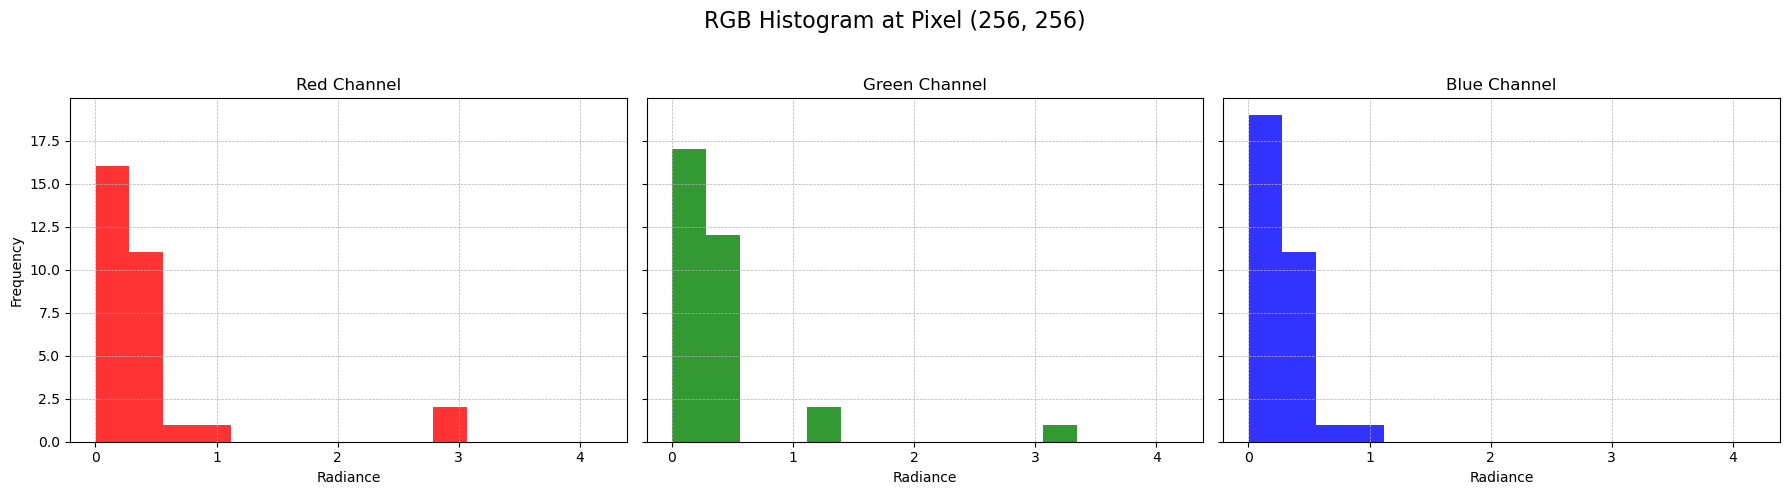

  5%|▍         | 1/21 [00:28<09:35, 28.76s/it]


Processing scene 2 of 21: ../data/train/banner_04

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [1.1109e-02, 4.3659e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [ 1  1  1 ... 15 13  8]
Num Bins:  16
Num Bins:  [0 1 1 ... 4 4 3]
Num Bins:  16
Num Bins:  [0 1 1 ... 5 4 3]
Zero samples: 4267599/25165824 (16.96%)


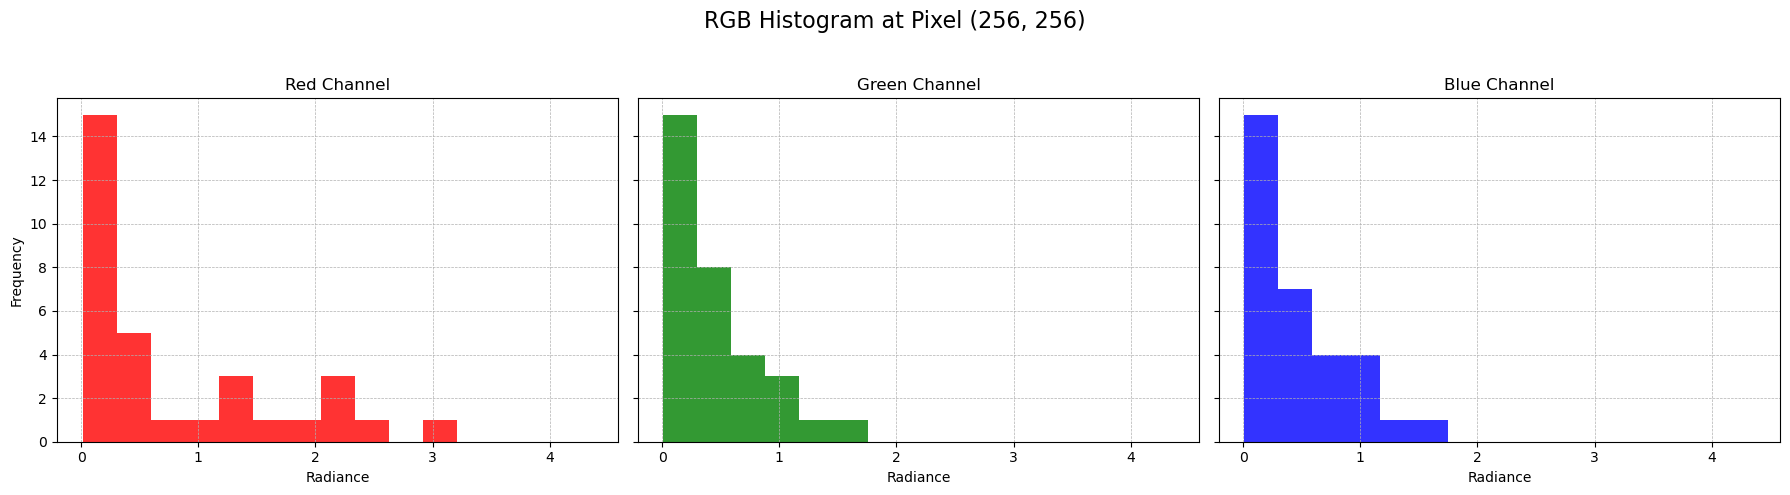

 10%|▉         | 2/21 [00:58<09:13, 29.12s/it]


Processing scene 3 of 21: ../data/train/banner_05

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [4.9111e-02, 1.1332e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 6 3 2]
Num Bins:  16
Num Bins:  [1 1 1 ... 2 1 1]
Num Bins:  16
Num Bins:  [1 2 1 ... 9 5 3]
Zero samples: 2088231/25165824 (8.30%)


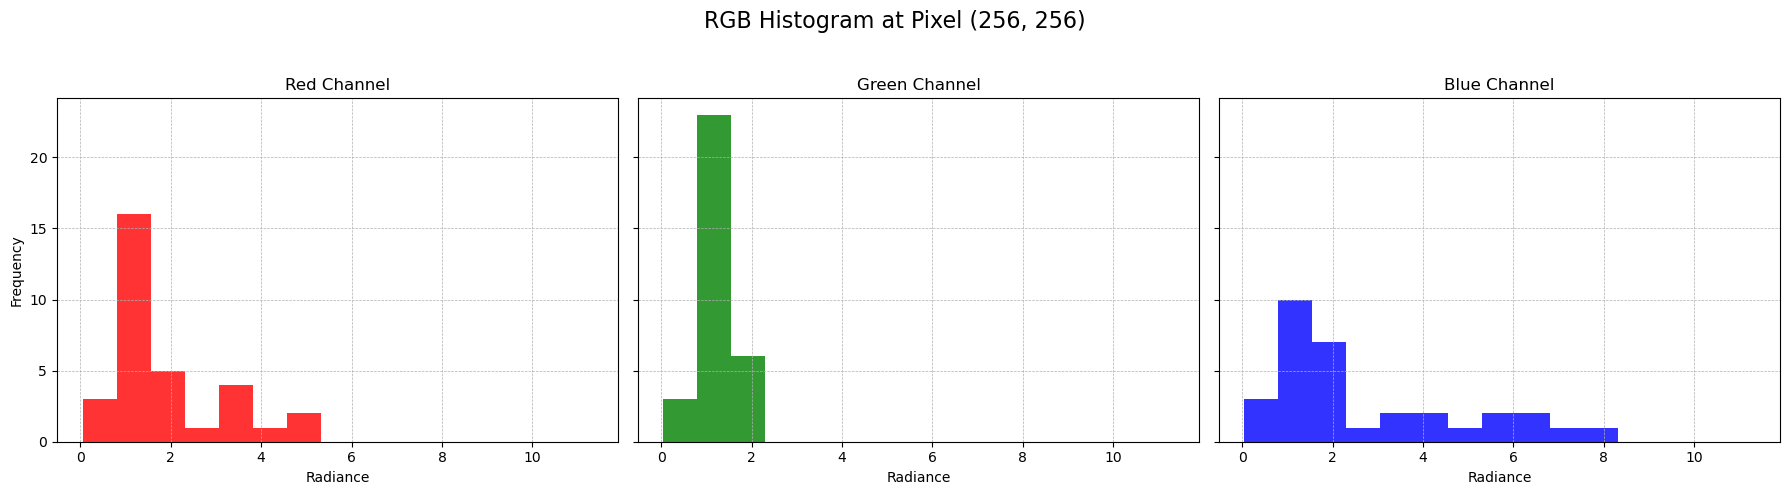

 14%|█▍        | 3/21 [01:24<08:20, 27.81s/it]


Processing scene 4 of 21: ../data/train/banner_07

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [4.4546e-07, 2.3776e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 5 0 2]
Num Bins:  16
Num Bins:  [1 1 1 ... 5 0 2]
Num Bins:  16
Num Bins:  [1 1 1 ... 5 0 2]
Zero samples: 2497605/25165824 (9.92%)


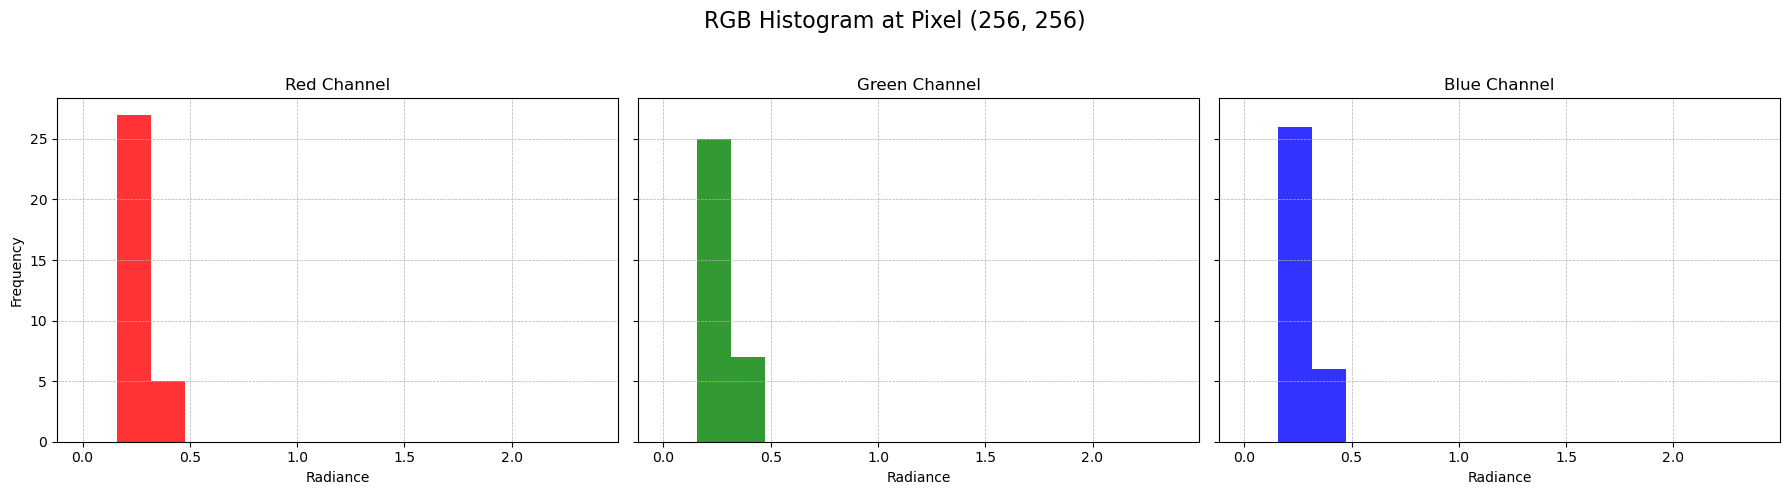

 19%|█▉        | 4/21 [01:47<07:19, 25.86s/it]


Processing scene 5 of 21: ../data/train/bathroom

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [2.5402e-05, 3.0000e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 1]
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 1]
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 1]
Zero samples: 13705368/25165824 (54.46%)


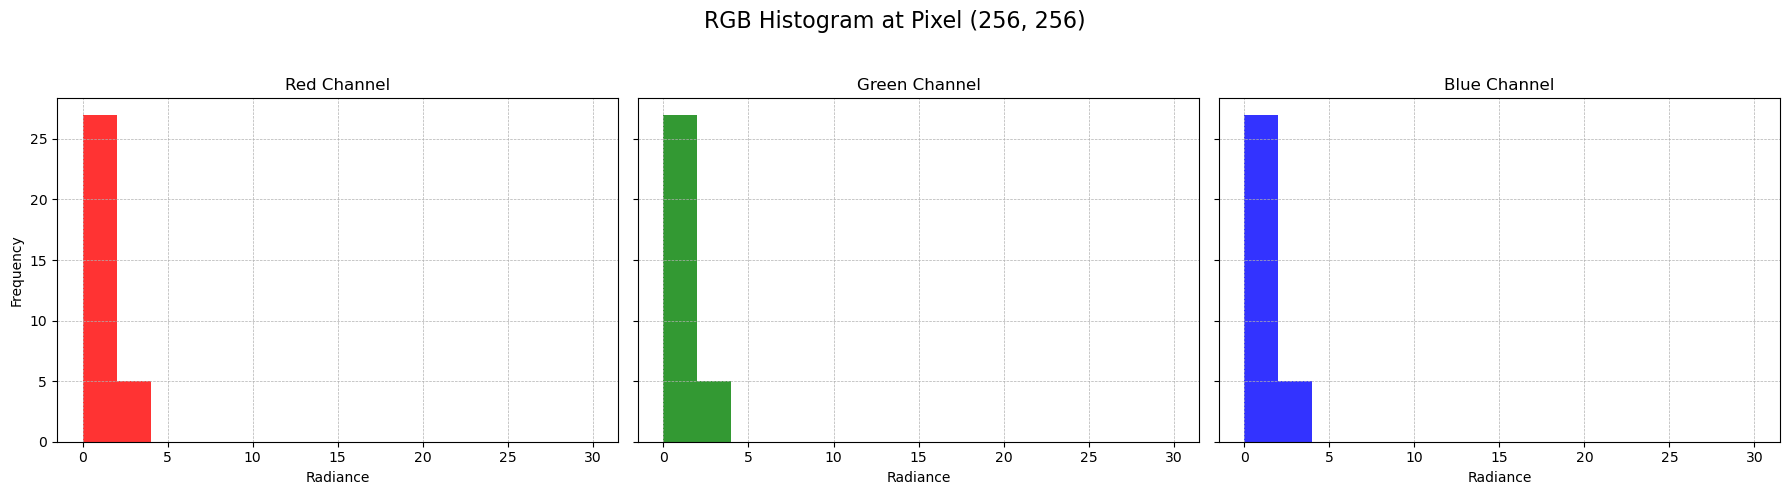

 24%|██▍       | 5/21 [02:29<08:30, 31.89s/it]


Processing scene 6 of 21: ../data/train/bedroom

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [2.2597e-05, 1.6583e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 0 0 ... 1 0 0]
Num Bins:  16
Num Bins:  [1 0 0 ... 1 0 0]
Num Bins:  16
Num Bins:  [1 0 0 ... 1 0 0]
Zero samples: 19612637/25165824 (77.93%)


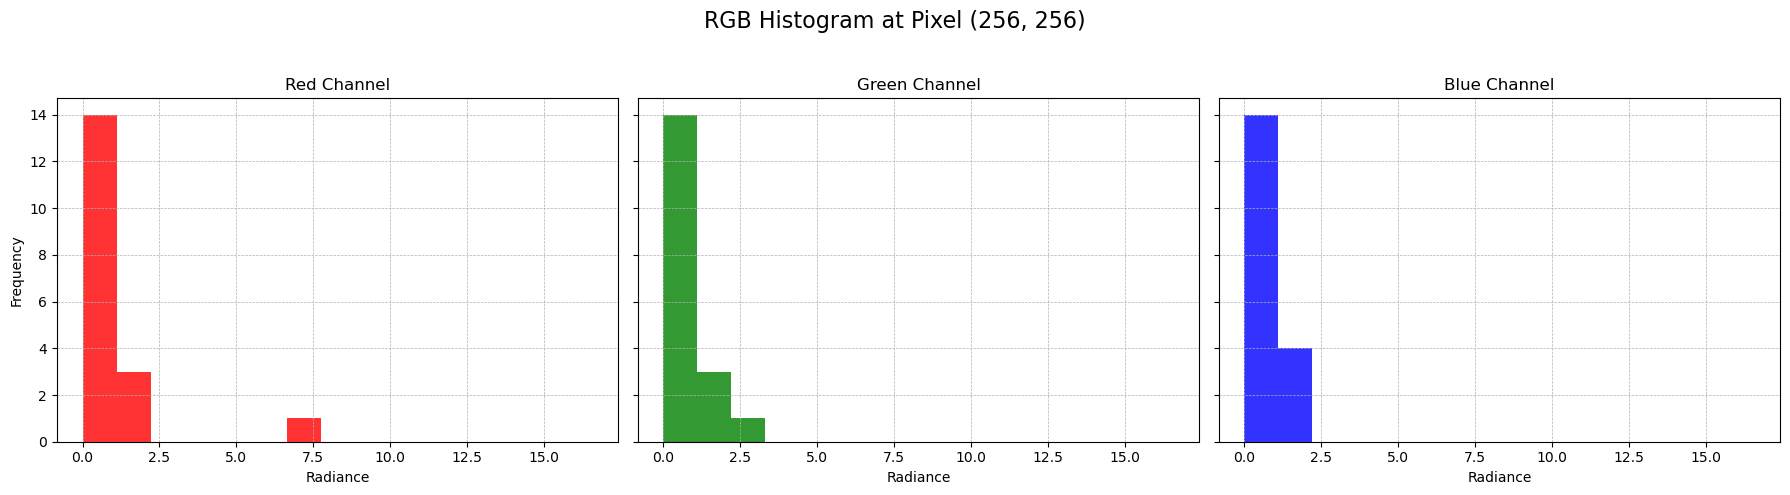

 29%|██▊       | 6/21 [03:24<09:52, 39.49s/it]


Processing scene 7 of 21: ../data/train/dining-room

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [5.4988e-05, 2.2316e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 0 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 0 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 0 0]
Zero samples: 14749854/25165824 (58.61%)


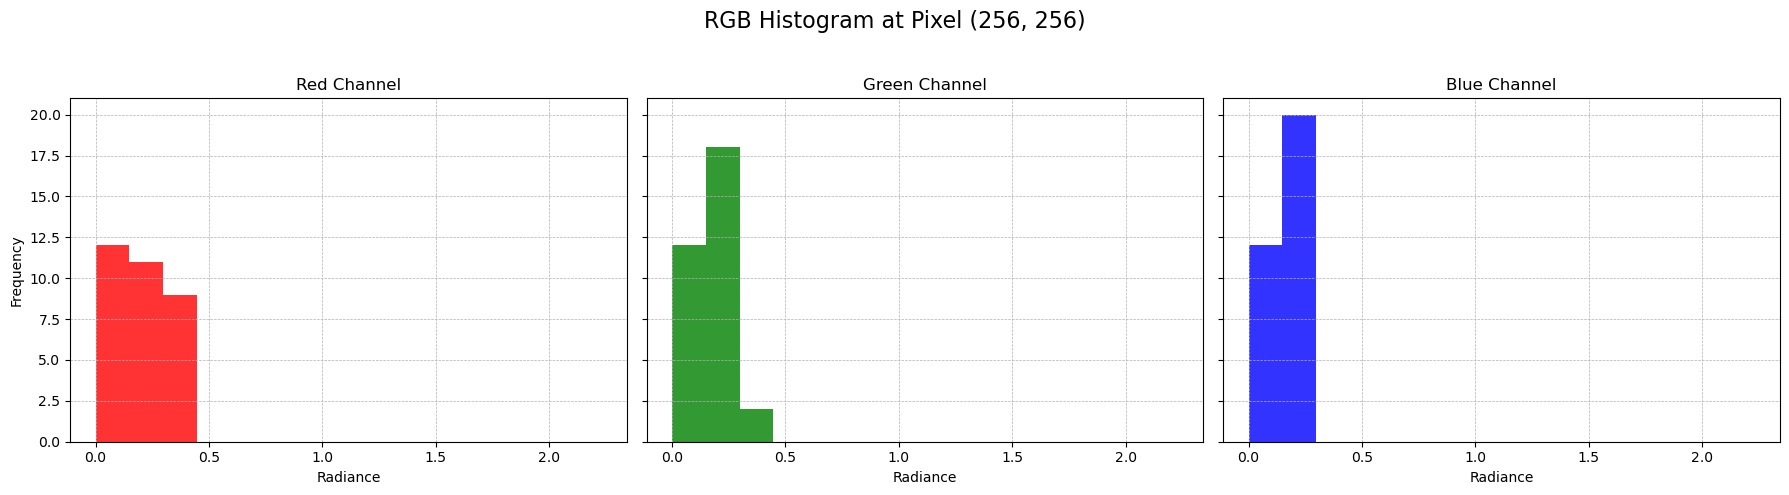

 33%|███▎      | 7/21 [04:06<09:25, 40.43s/it]


Processing scene 8 of 21: ../data/train/glass-of-water

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [3.7383e-03, 2.8361e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Zero samples: 5047482/25165824 (20.06%)


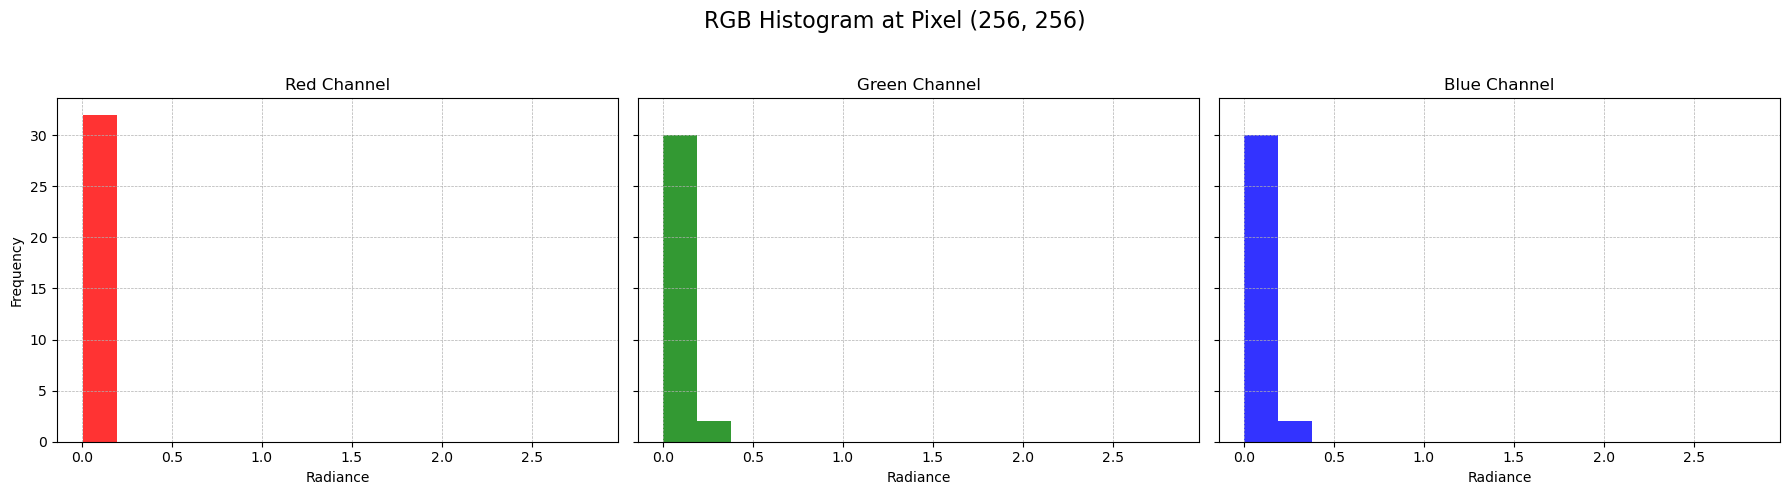

 38%|███▊      | 8/21 [04:33<07:50, 36.16s/it]


Processing scene 9 of 21: ../data/train/house

 XML File Name: scene-above
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [4.7991e-04, 1.1881e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [ 1  1  1 ... 11 10  5]
Num Bins:  16
Num Bins:  [1 1 1 ... 9 9 7]
Num Bins:  16
Num Bins:  [ 1  1  1 ...  8  9 10]
Zero samples: 3413364/25165824 (13.56%)


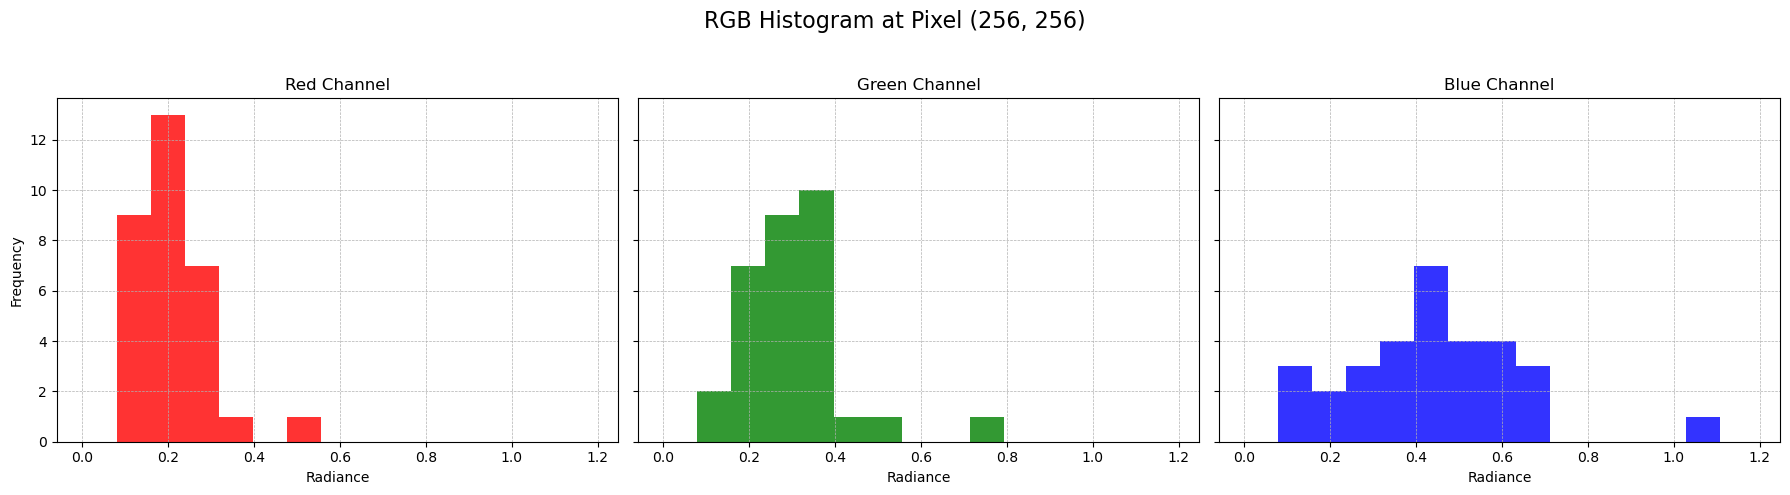


 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [3.7003e-04, 1.1242e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [ 1  1  1 ... 11 11  5]
Num Bins:  16
Num Bins:  [ 1  1  1 ... 10 10  8]
Num Bins:  16
Num Bins:  [ 1  1  0 ...  9  9 11]
Zero samples: 5754099/25165824 (22.86%)


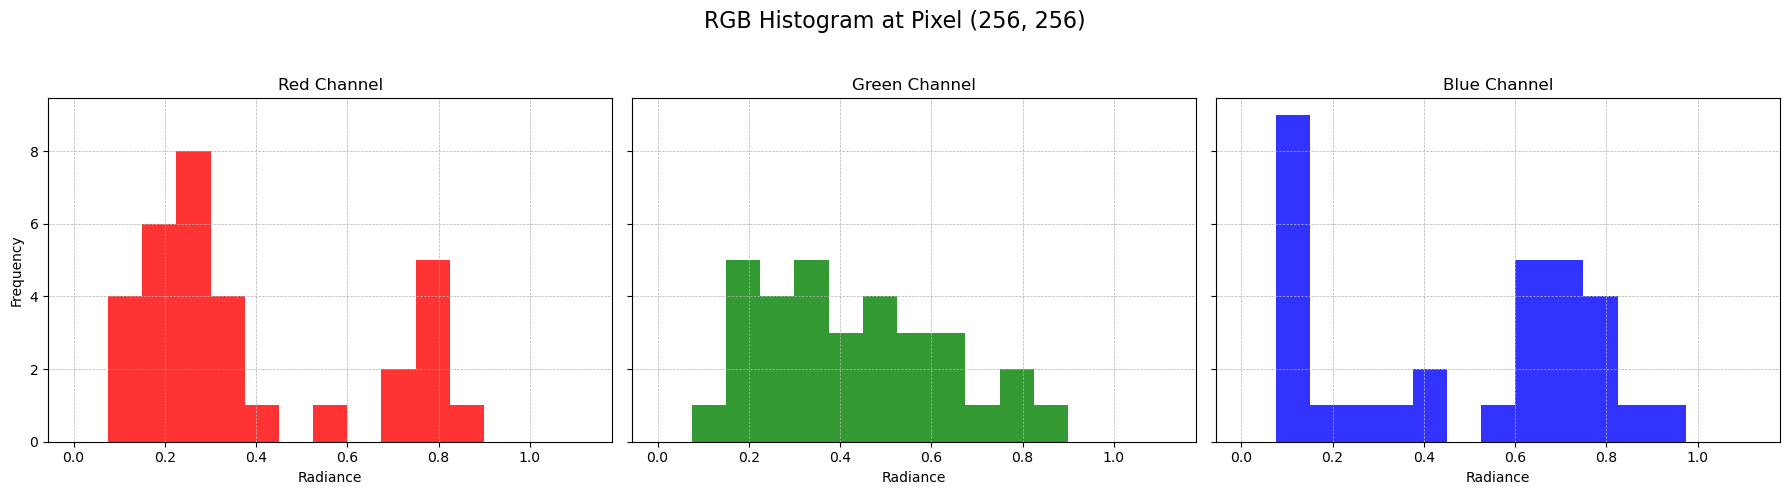

 43%|████▎     | 9/21 [05:33<08:42, 43.51s/it]


Processing scene 10 of 21: ../data/train/kitchen

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [8.7061e-07, 1.6032e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [0 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [0 1 1 ... 1 1 1]
Zero samples: 9967782/25165824 (39.61%)


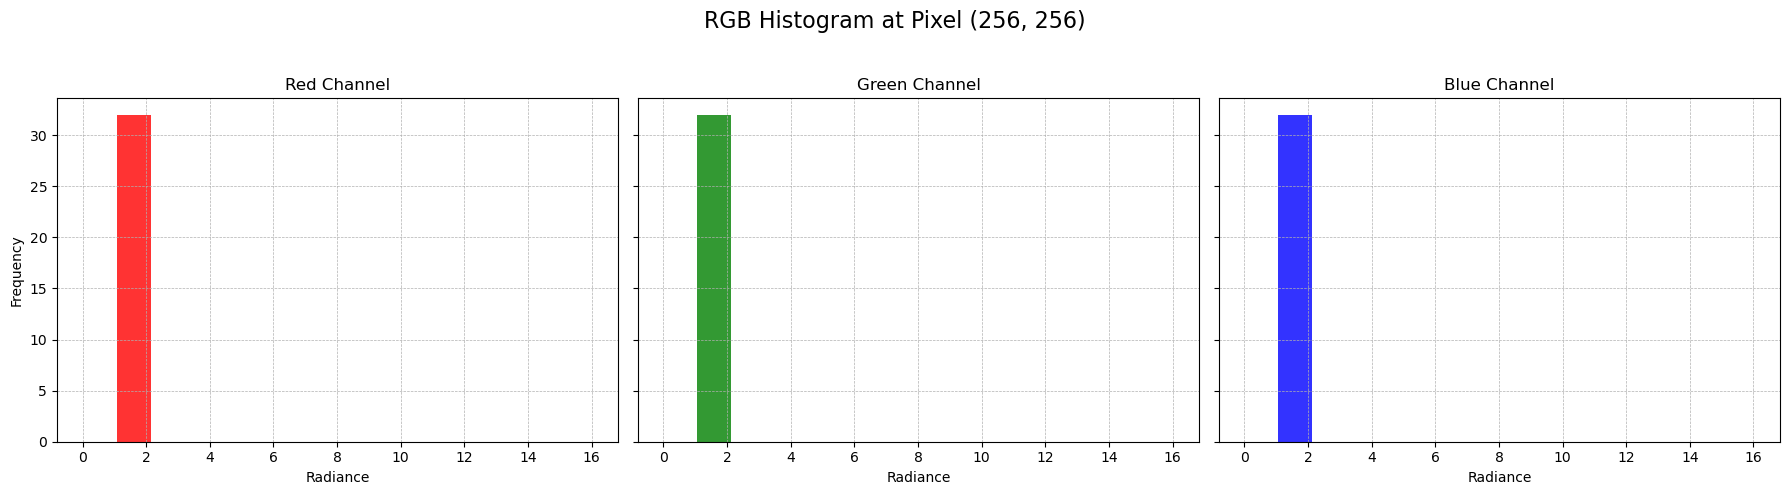

 48%|████▊     | 10/21 [06:12<07:45, 42.31s/it]


Processing scene 11 of 21: ../data/train/lamp

 XML File Name: scene-above
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [7.7871e-04, 1.5217e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 0 ... 6 4 3]
Num Bins:  16
Num Bins:  [1 1 0 ... 6 4 3]
Num Bins:  16
Num Bins:  [1 1 0 ... 6 4 3]
Zero samples: 9424470/25165824 (37.45%)


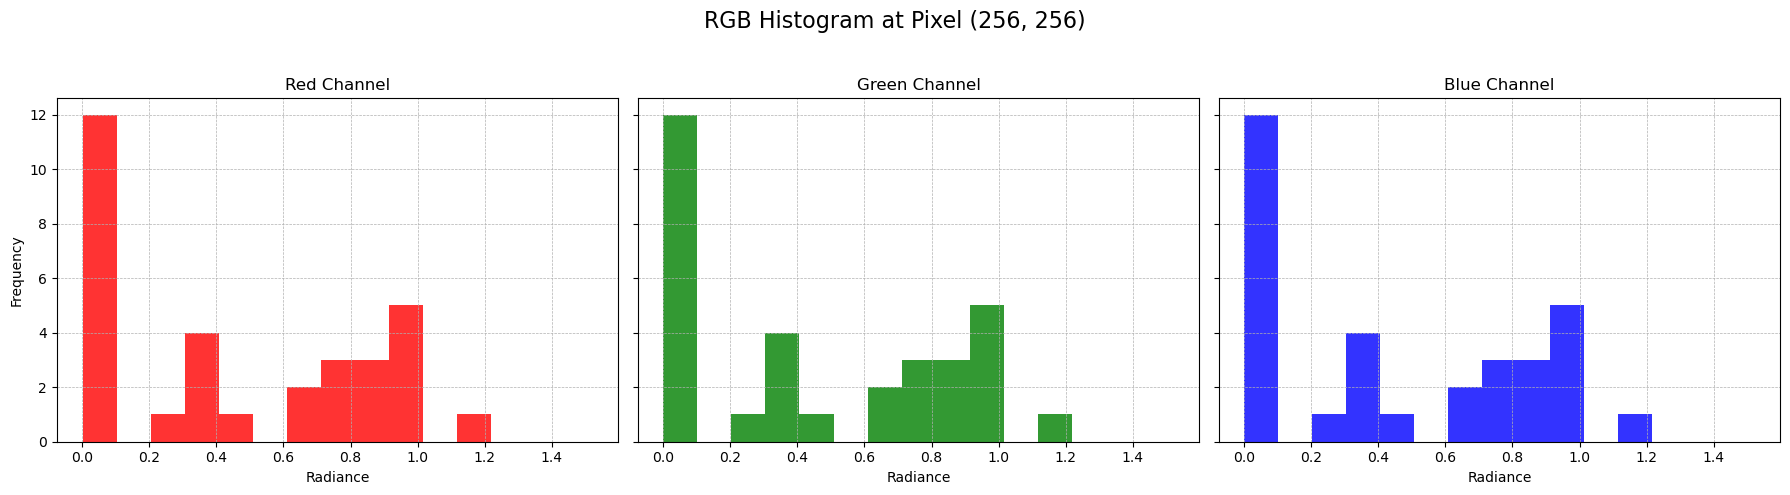


 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [9.0411e-04, 1.9382e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 0 0 ... 6 3 3]
Num Bins:  16
Num Bins:  [0 0 0 ... 6 3 3]
Num Bins:  16
Num Bins:  [0 0 0 ... 6 3 3]
Zero samples: 8290614/25165824 (32.94%)


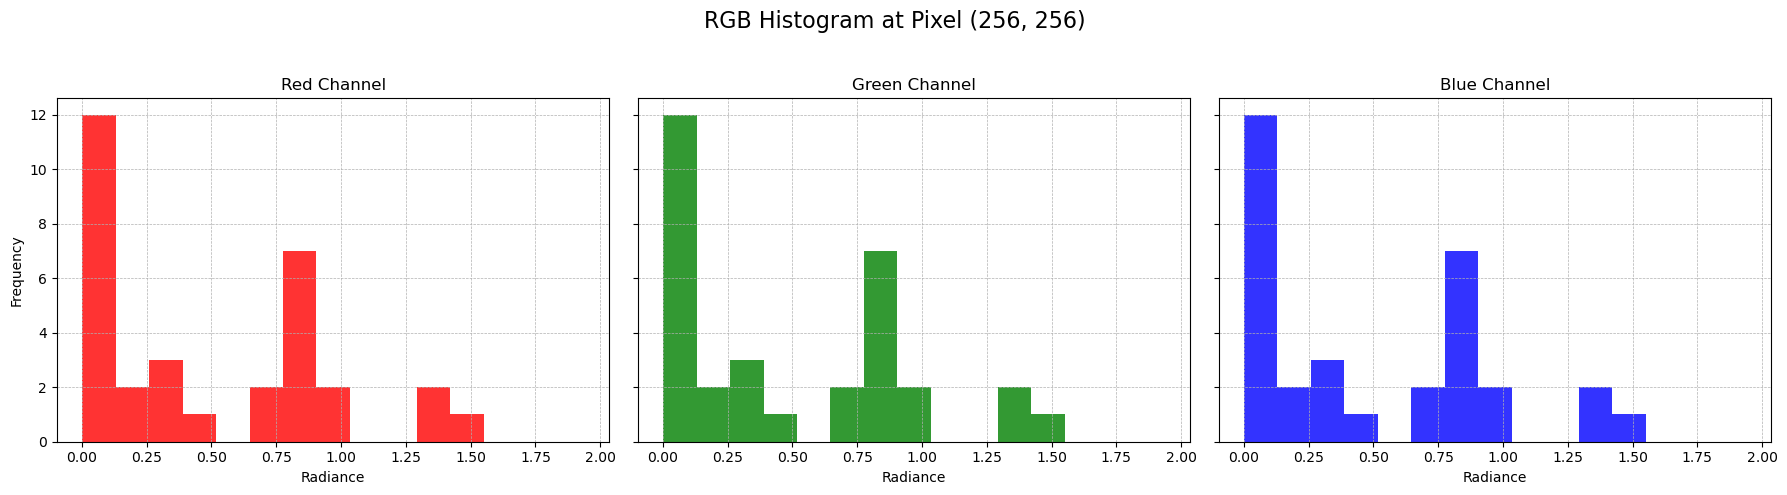

 52%|█████▏    | 11/21 [06:54<07:02, 42.22s/it]


Processing scene 12 of 21: ../data/train/living-room

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [9.4798e-05, 7.5639e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 1 0 0]
Zero samples: 18942941/25165824 (75.27%)


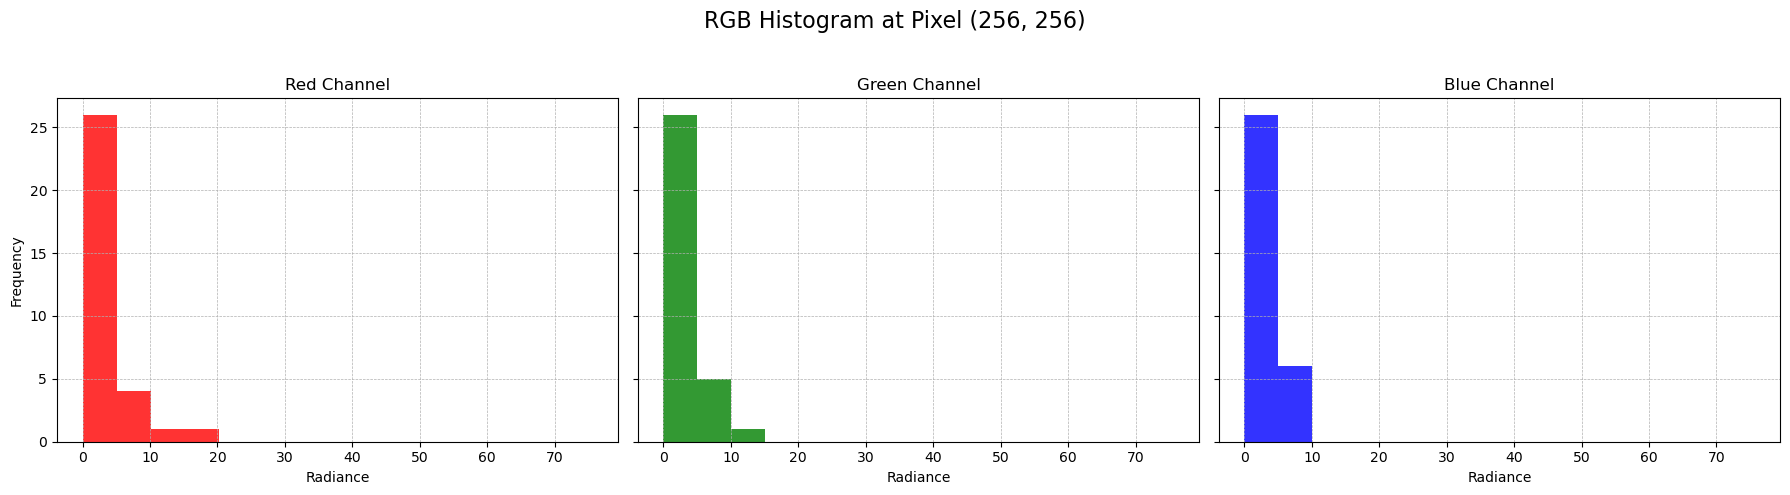

 57%|█████▋    | 12/21 [07:45<06:42, 44.68s/it]


Processing scene 13 of 21: ../data/train/living-room-2

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [8.0041e-05, 1.7777e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Zero samples: 2285820/25165824 (9.08%)


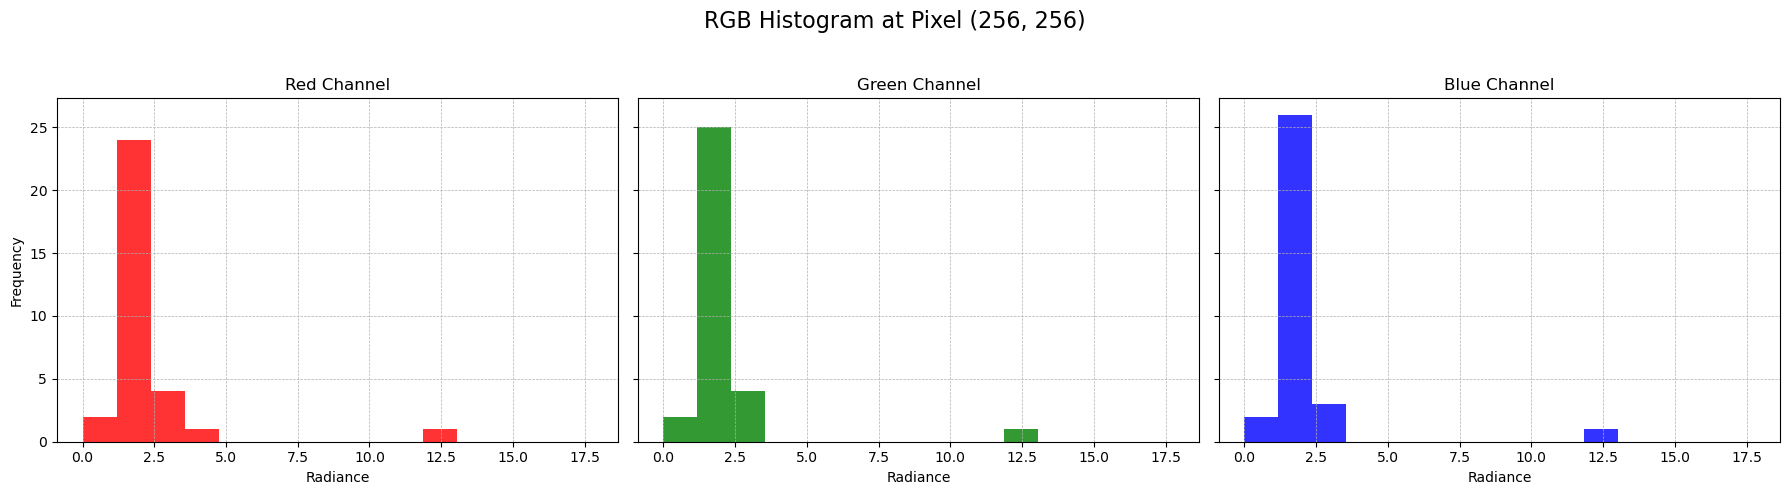

 62%|██████▏   | 13/21 [08:34<06:09, 46.15s/it]


Processing scene 14 of 21: ../data/train/matpreview

 XML File Name: scene-above
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [3.1168e-03, 2.2224e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 3 ... 1 1 2]
Num Bins:  16
Num Bins:  [1 1 4 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 5 ... 1 1 1]
Zero samples: 500133/25165824 (1.99%)


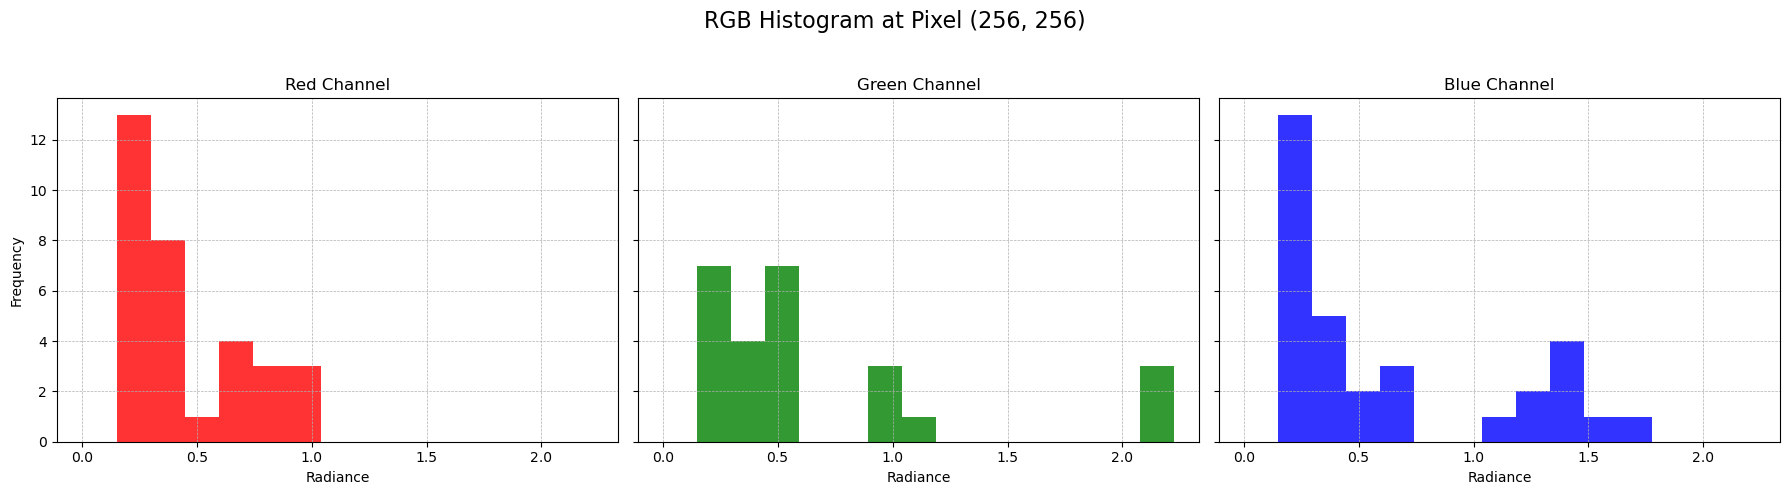


 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [1.9628e-03, 3.7023e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [3 2 7 ... 2 1 1]
Num Bins:  16
Num Bins:  [2 2 9 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 9 ... 1 1 1]
Zero samples: 1267962/25165824 (5.04%)


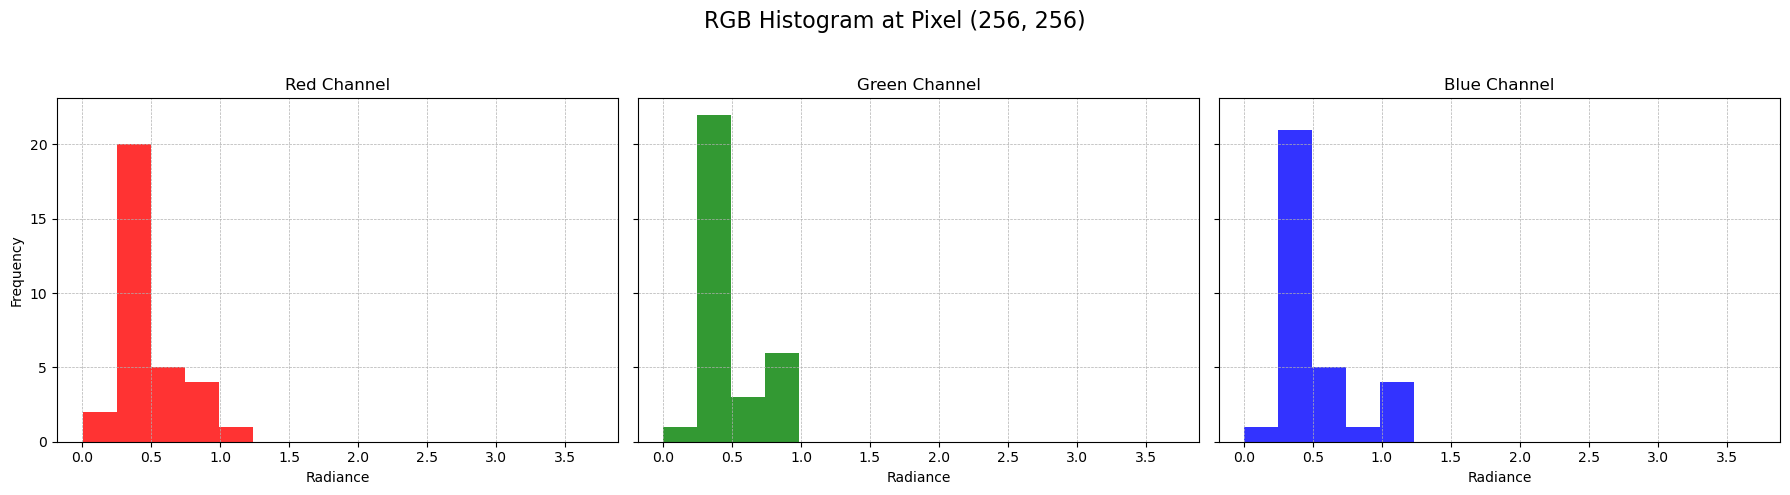

 67%|██████▋   | 14/21 [09:35<05:54, 50.60s/it]


Processing scene 15 of 21: ../data/train/spaceship

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [8.1677e-06, 6.4326e-01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Zero samples: 1489935/25165824 (5.92%)


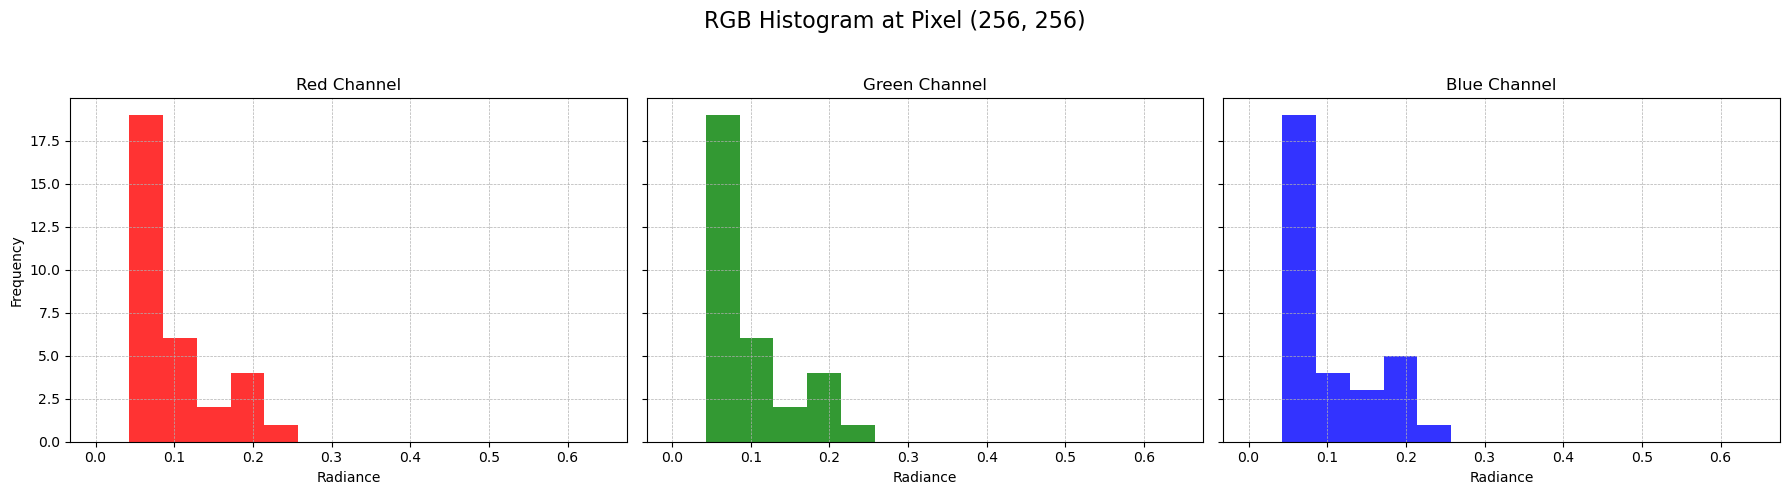

 71%|███████▏  | 15/21 [09:59<04:14, 42.48s/it]


Processing scene 16 of 21: ../data/train/staircase

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [3.3189e-05, 1.7414e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 1 0 ... 0 0 1]
Num Bins:  16
Num Bins:  [0 1 0 ... 0 0 1]
Num Bins:  16
Num Bins:  [0 1 0 ... 0 0 1]
Zero samples: 5856928/25165824 (23.27%)


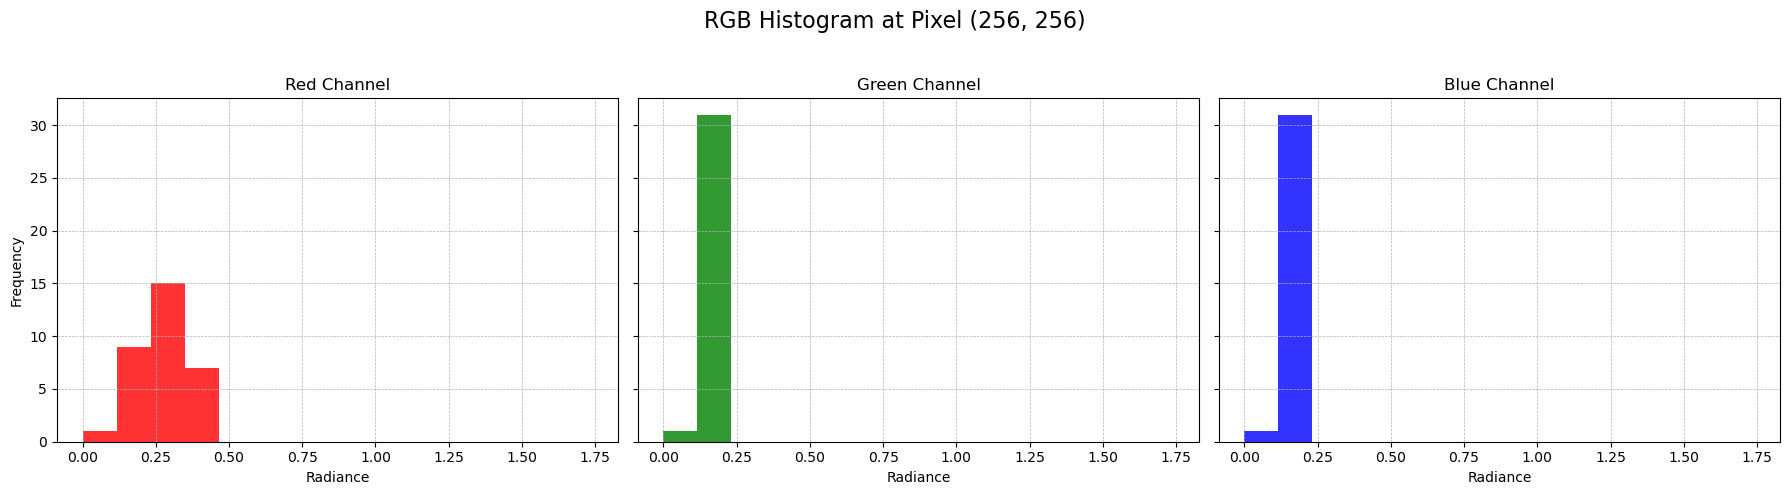

 76%|███████▌  | 16/21 [10:49<03:43, 44.72s/it]


Processing scene 17 of 21: ../data/train/staircase2

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [8.2807e-07, 4.5750e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 0 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 0 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 0 ... 1 1 1]
Zero samples: 3617508/25165824 (14.37%)


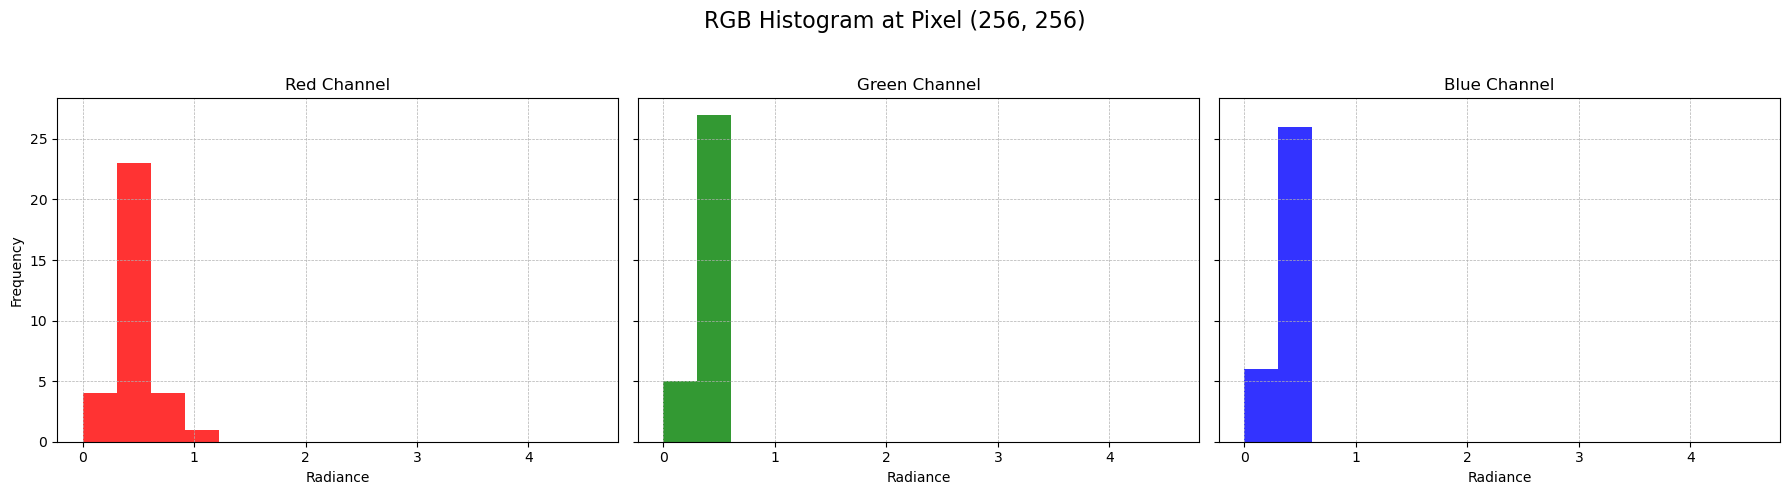

 81%|████████  | 17/21 [11:21<02:44, 41.17s/it]


Processing scene 18 of 21: ../data/train/veach-ajar

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [7.6318e-03, 9.8508e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [2 0 0 ... 0 0 0]
Num Bins:  16
Num Bins:  [2 0 0 ... 0 0 0]
Num Bins:  16
Num Bins:  [2 0 0 ... 0 0 0]
Zero samples: 22780095/25165824 (90.52%)


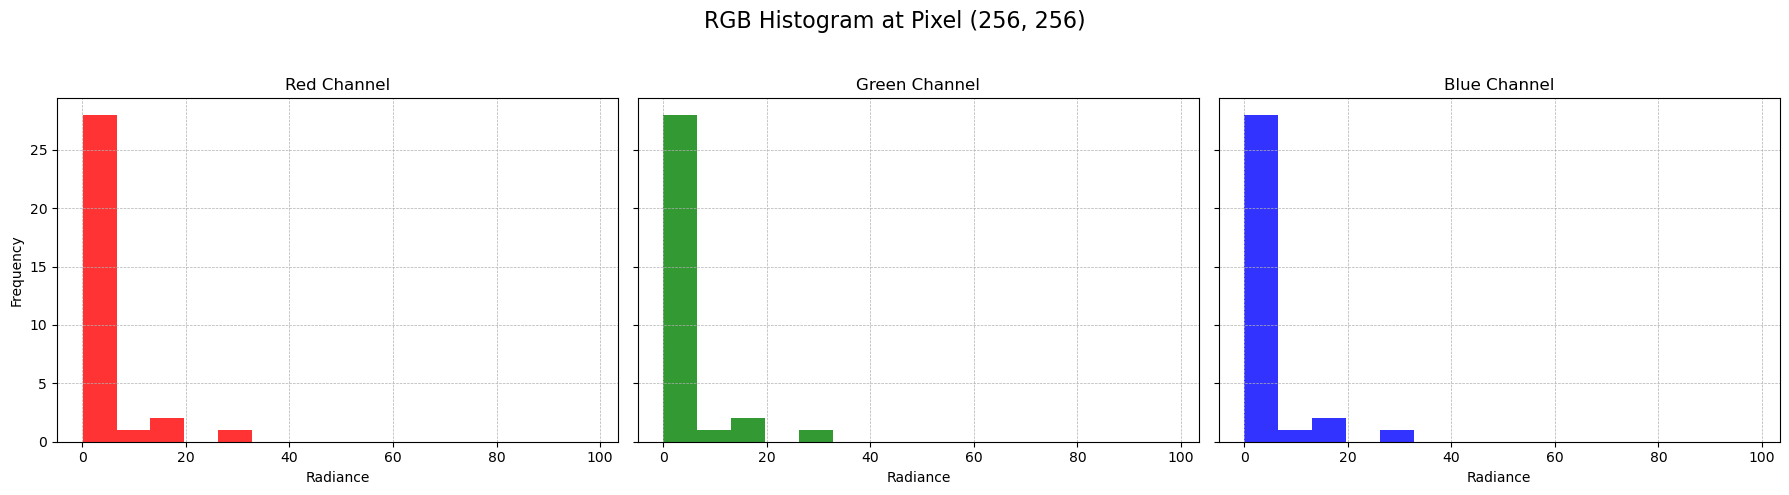

 86%|████████▌ | 18/21 [12:03<02:03, 41.30s/it]


Processing scene 19 of 21: ../data/train/veach-bidir

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [5.0304e-03, 1.1032e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 0 0 ... 0 1 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 0 1 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 0 1 0]
Zero samples: 17804091/25165824 (70.75%)


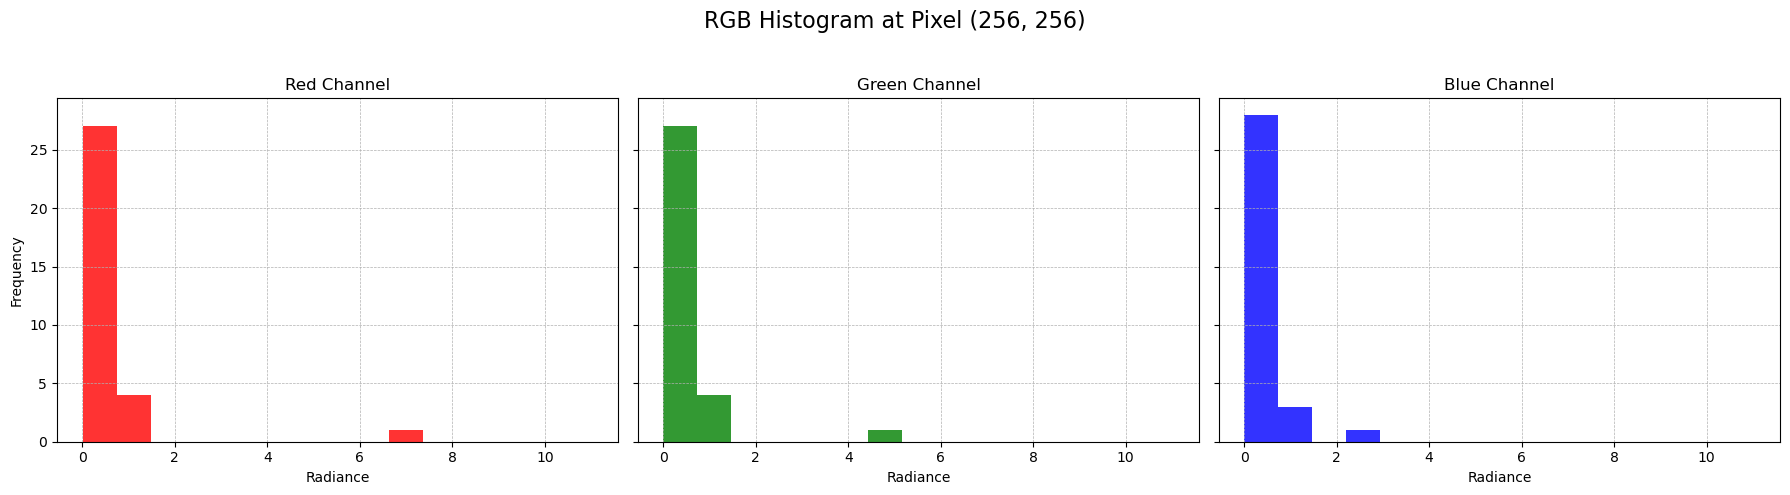

 90%|█████████ | 19/21 [12:34<01:16, 38.08s/it]


Processing scene 20 of 21: ../data/train/veach-mis

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [4.6578e-04, 3.0396e+01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 0]
Zero samples: 5298183/25165824 (21.05%)


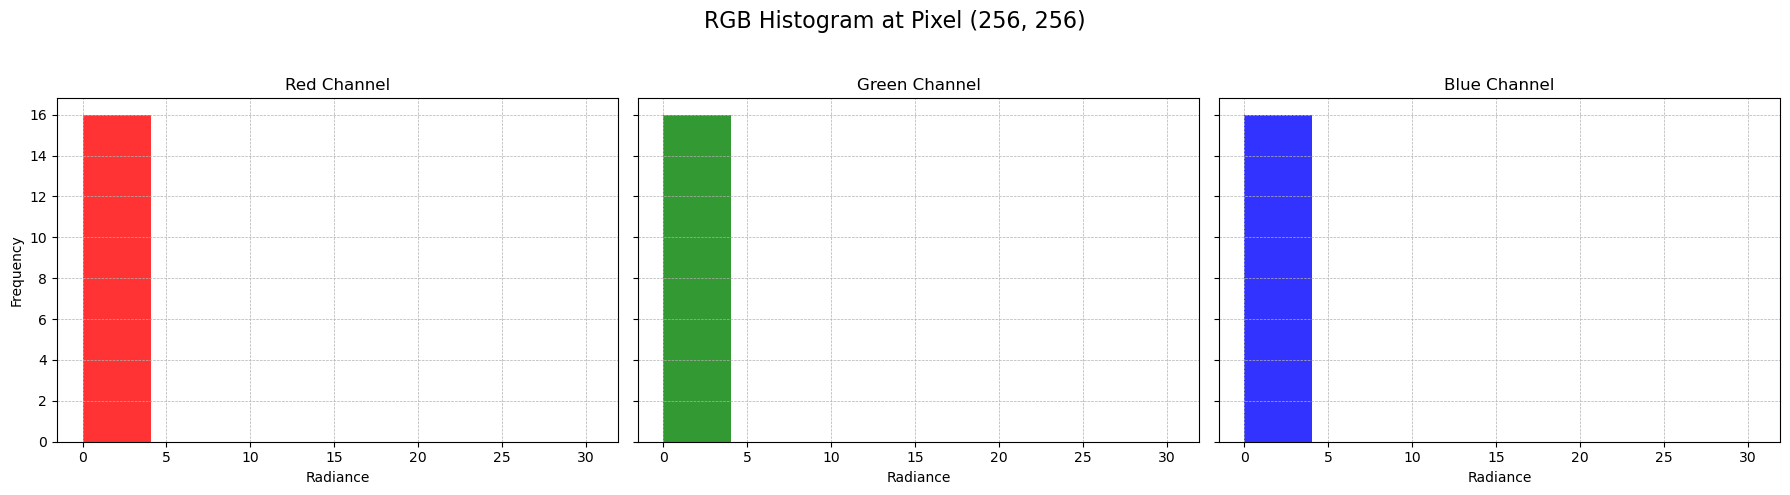

 95%|█████████▌| 20/21 [12:55<00:32, 33.00s/it]


Processing scene 21 of 21: ../data/train/volumetric-caustic

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [2.0873e-03, 1.2283e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 0 0 ... 0 0 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 0 0 0]
Num Bins:  16
Num Bins:  [0 0 0 ... 0 0 0]
Zero samples: 3059286/25165824 (12.16%)


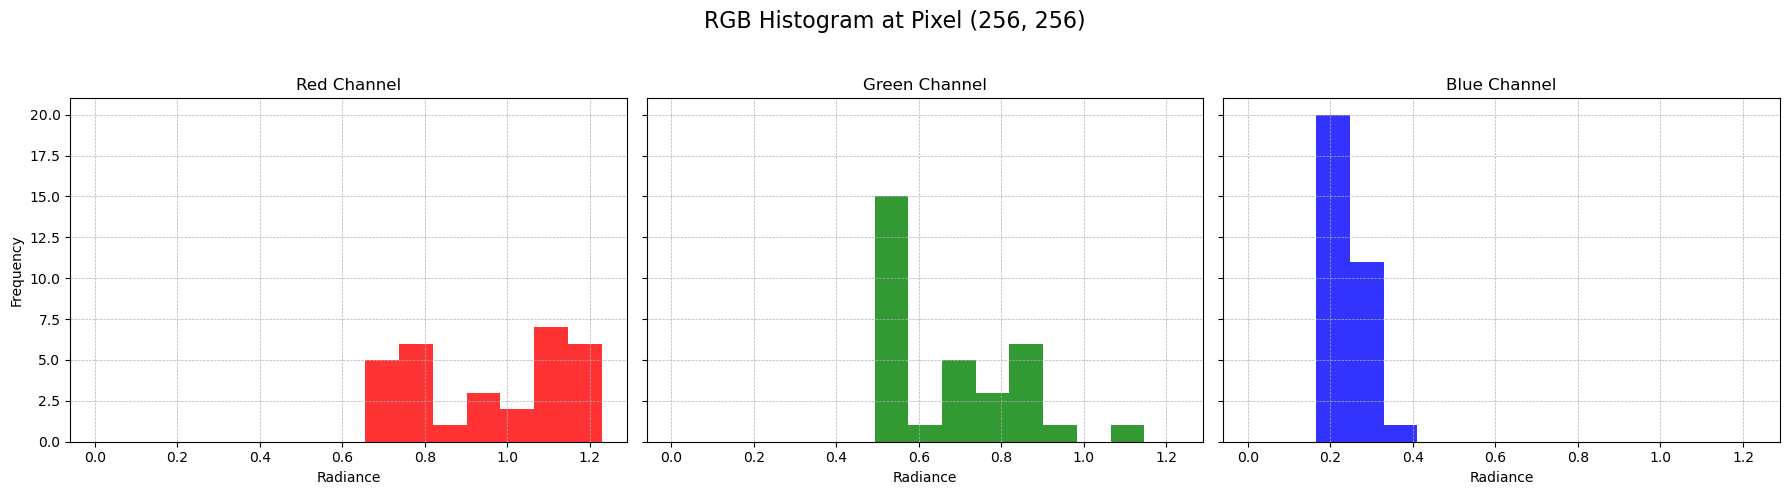

100%|██████████| 21/21 [13:20<00:00, 38.11s/it]


In [19]:
# Train Scenes
scene_processing_pipeline(train_scenes, gen_clean=False, plot_hist=True)

  0%|          | 0/6 [00:00<?, ?it/s]


Processing scene 1 of 6: ../data/test/banner_01

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [7.5342e-03, 1.8204e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 1 1 ... 8 6 4]
Num Bins:  16
Num Bins:  [ 1  1  1 ... 15 14  9]
Num Bins:  16
Num Bins:  [0 0 0 ... 7 5 3]
Zero samples: 416913/25165824 (1.66%)


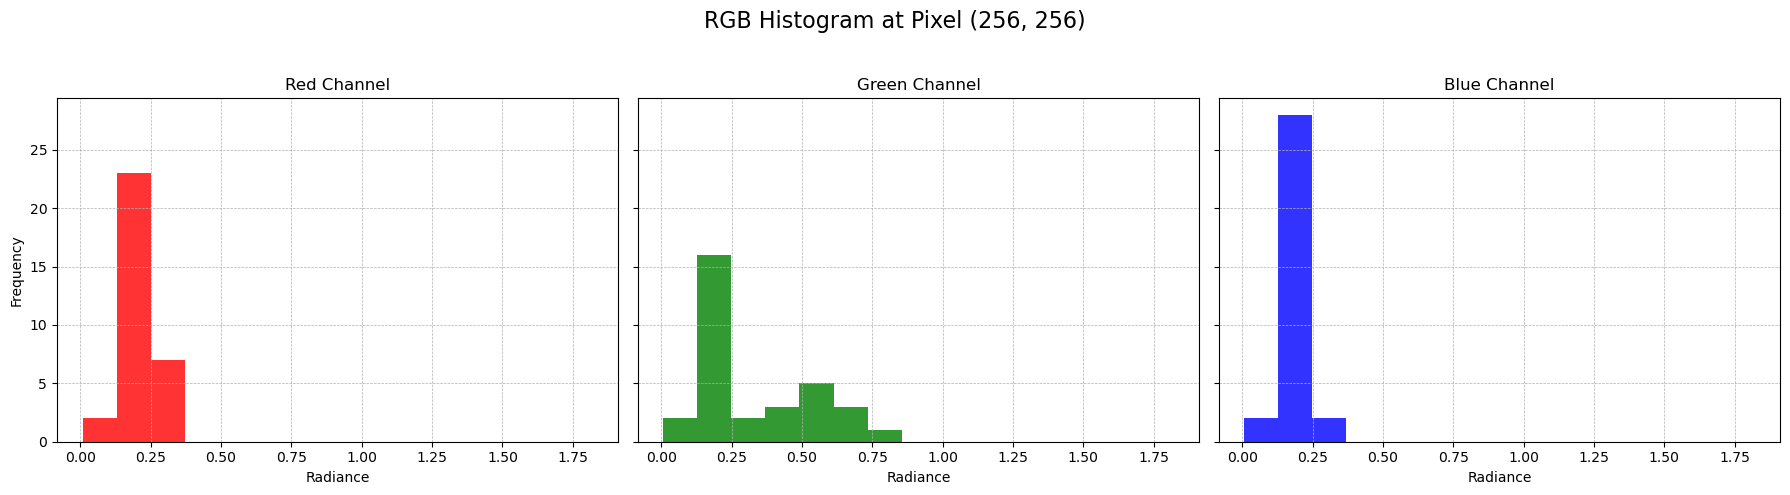

 17%|█▋        | 1/6 [00:21<01:49, 21.98s/it]


Processing scene 2 of 6: ../data/test/bathroom2

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [3.4239e-04, 1.2500e+02]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Num Bins:  16
Num Bins:  [1 1 1 ... 1 1 1]
Zero samples: 2093295/25165824 (8.32%)


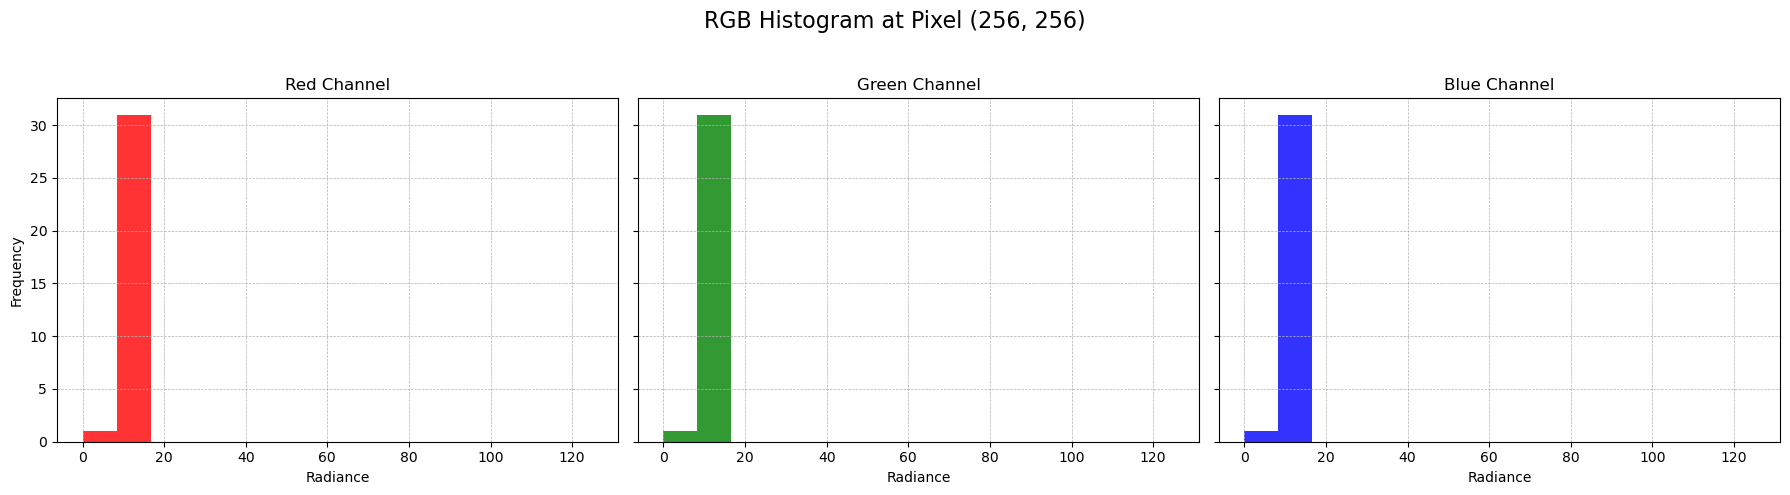

 33%|███▎      | 2/6 [00:59<02:03, 30.94s/it]


Processing scene 3 of 6: ../data/test/classroom

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [1.1045e-03, 3.7501e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [2 0 0 ... 2 0 0]
Num Bins:  16
Num Bins:  [2 0 0 ... 2 0 0]
Num Bins:  16
Num Bins:  [3 0 0 ... 1 0 0]
Zero samples: 16632636/25165824 (66.09%)


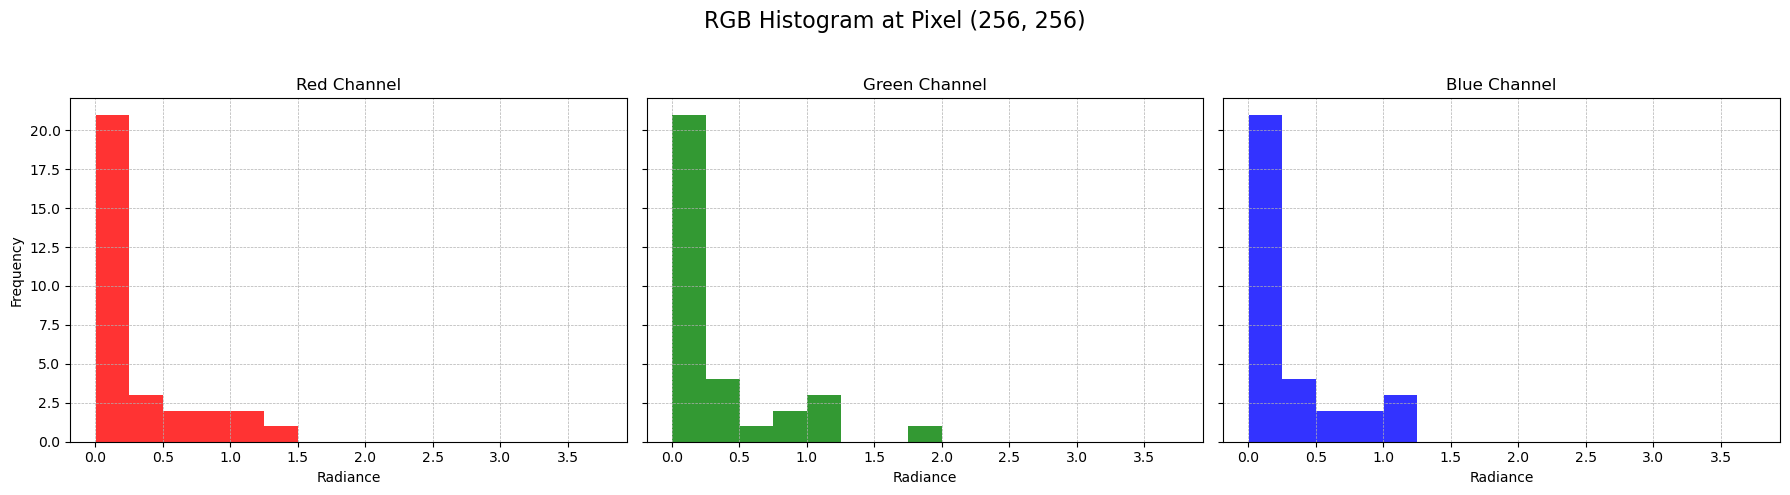

 50%|█████     | 3/6 [01:42<01:49, 36.36s/it]


Processing scene 4 of 6: ../data/test/cornell-box

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [2.5316e-04, 6.0981e-01]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [0 1 4 ... 3 3 2]
Num Bins:  16
Num Bins:  [0 0 1 ... 3 3 2]
Num Bins:  16
Num Bins:  [0 0 1 ... 1 1 1]
Zero samples: 3785499/25165824 (15.04%)


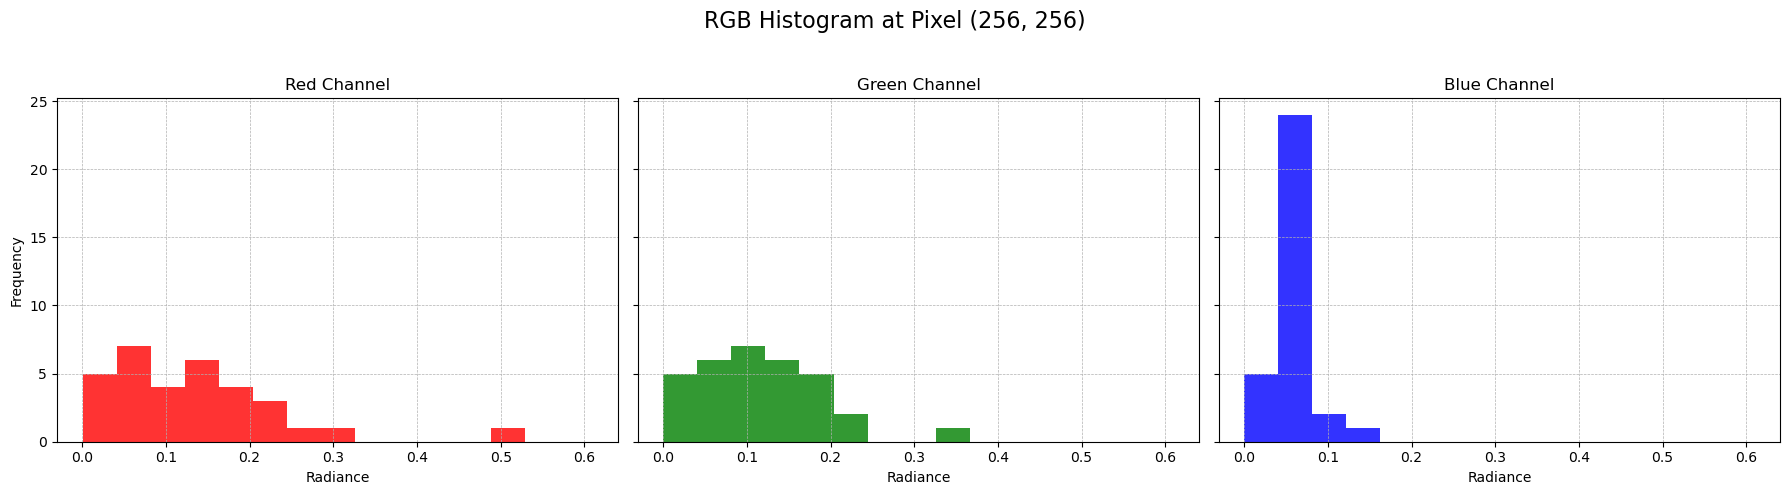

 67%|██████▋   | 4/6 [02:01<00:59, 29.80s/it]


Processing scene 5 of 6: ../data/test/living-room-3

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [2.5203e-04, 3.6545e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [2 7 1 ... 4 1 2]
Num Bins:  16
Num Bins:  [2 6 1 ... 3 1 1]
Num Bins:  16
Num Bins:  [2 5 1 ... 1 1 1]
Zero samples: 932597/25165824 (3.71%)


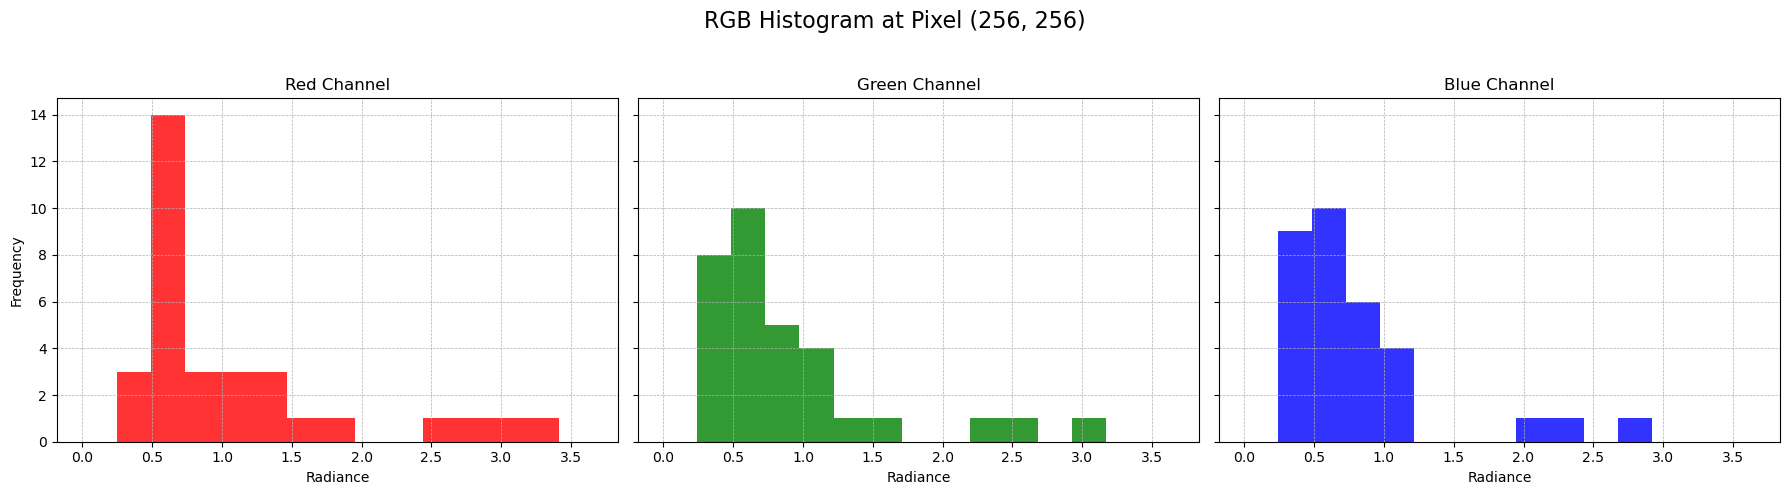

 83%|████████▎ | 5/6 [02:46<00:35, 35.33s/it]


Processing scene 6 of 6: ../data/test/teapot-full

 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [1.1809e-02, 2.8446e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Num Bins:  16
Num Bins:  [3 2 2 ... 2 1 2]
Num Bins:  16
Num Bins:  [5 1 2 ... 3 1 2]
Num Bins:  16
Num Bins:  [9 1 2 ... 5 1 3]
Zero samples: 2329088/25165824 (9.25%)


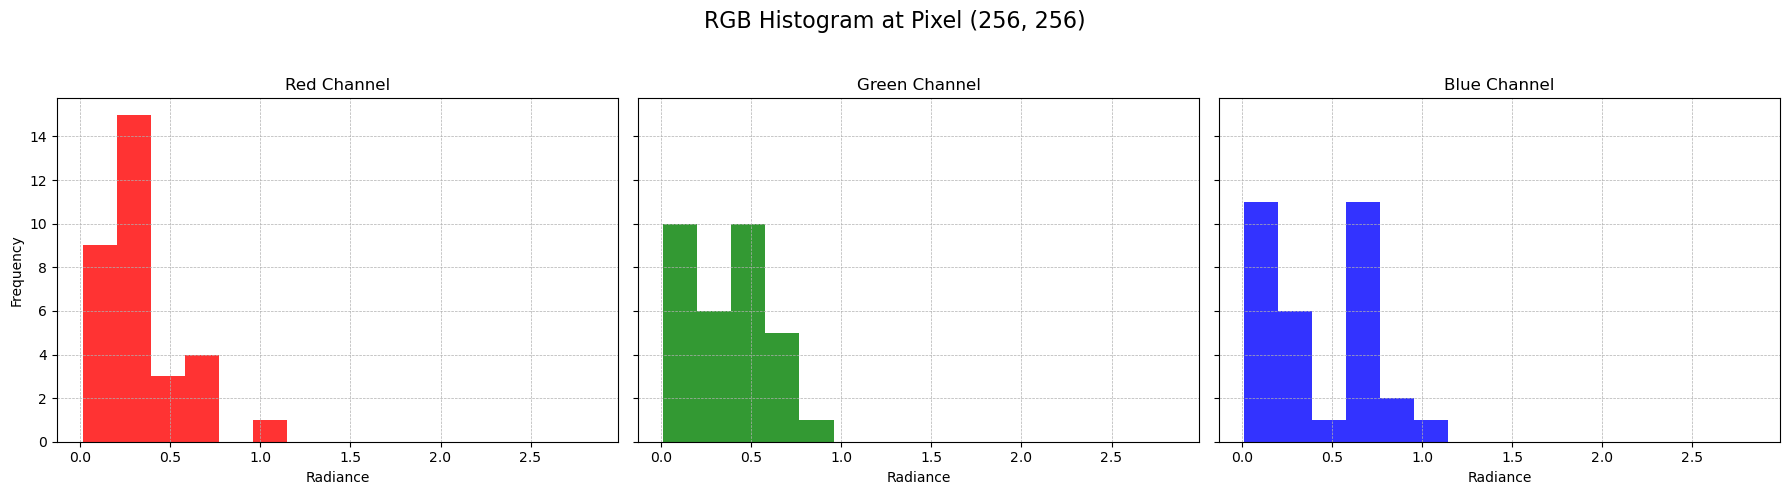

100%|██████████| 6/6 [03:11<00:00, 31.90s/it]


In [20]:
# Test Scenes
scene_processing_pipeline(test_scenes, gen_clean=False, plot_hist=True)

# Pixel Plots

In [14]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the parent directory (project root) and add it to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)


from dataset.HistogramGenerator import generate_histograms

In [17]:
scene_dir = "../data/classroom"

def plot_hist(scene_dir, spp, bins, log):
    # px, py = WIDTH // 2, HEIGHT // 2
    px, py = 250, 100
    height, width = 512, 512
    zoom_size = 20  # Half-width of zoomed-in region

    scene_dir = Path(scene_dir)

    # Find all XML files
    xml_files = list(scene_dir.rglob("*.xml"))
    xml_files = [f for f in xml_files if not f.name.startswith("._") and "__MACOSX" not in str(f)]

    for xml_path in xml_files:
        cam_name = xml_path.stem
        print(f"\n XML File Name: {cam_name}")
        
        # Load scene
        scene = mi.load_file(str(xml_path))
        
        # Generate histograms and mean image
        histograms, bin_edges = generate_histograms(scene, low_spp=spp, num_bins=bins)
        avg_img = get_average_image(histograms, bin_edges, height, width)

        # Show mean image and draw red square
        # Set up figure with 2 subplots: full image + zoomed image
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # --- Full Image ---
        axs[0].imshow(avg_img)
        axs[0].set_title(f"Full Image - {cam_name}")
        axs[0].axis('off')
        rect = patches.Rectangle((py - 0.5, px - 0.5), 1, 1,
                                linewidth=2, edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)

        # --- Zoomed-in Region ---
        axs[1].imshow(avg_img)
        axs[1].set_title(f"Zoomed-In View at ({px}, {py})")
        axs[1].set_xlim(py - zoom_size, py + zoom_size)
        axs[1].set_ylim(px + zoom_size, px - zoom_size)
        axs[1].axis('off')
        rect_zoom = patches.Rectangle((py - 0.5, px - 0.5), 1, 1,
                                    linewidth=2, edgecolor='red', facecolor='none')
        axs[1].add_patch(rect_zoom)

        plt.tight_layout()
        plt.show()

        # Extract and plot RGB histogram at pixel
        plot_rgb_histograms(histograms, px=px, py=py, bin_edges=bin_edges, use_log=log)

        plt.tight_layout()
        plt.show()
        return histograms, bin_edges

In [18]:
plot_hist("../data/classroom", 32, 16, log=False)


 XML File Name: scene


AttributeError: 'Scene' object has no attribute 'shape'


 XML File Name: scene
Range Val: 10
SPP: 32
Total Pixels: 262144
Linear estimated radiance range: [1.1045e-03, 3.7501e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 32, 3)
Accumulating Histogram ...
Zero samples: 16632673/25165824 (66.09%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0011044664..3.5704298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0011044664..3.5704298].


Average Histogram Shape:  (512, 512, 3)


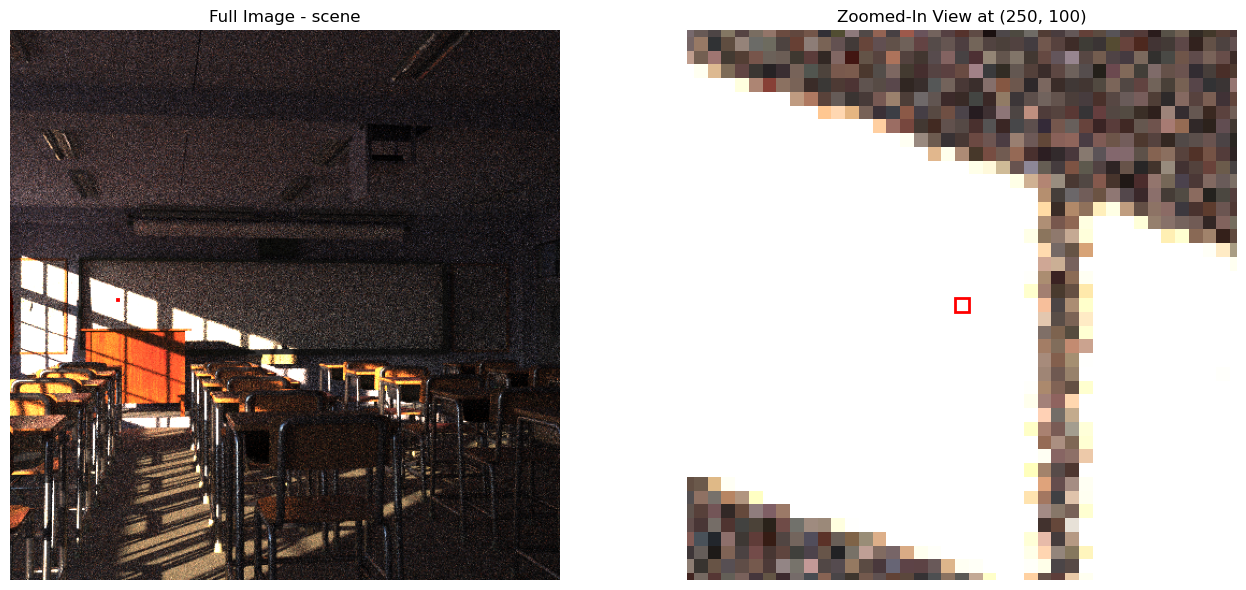

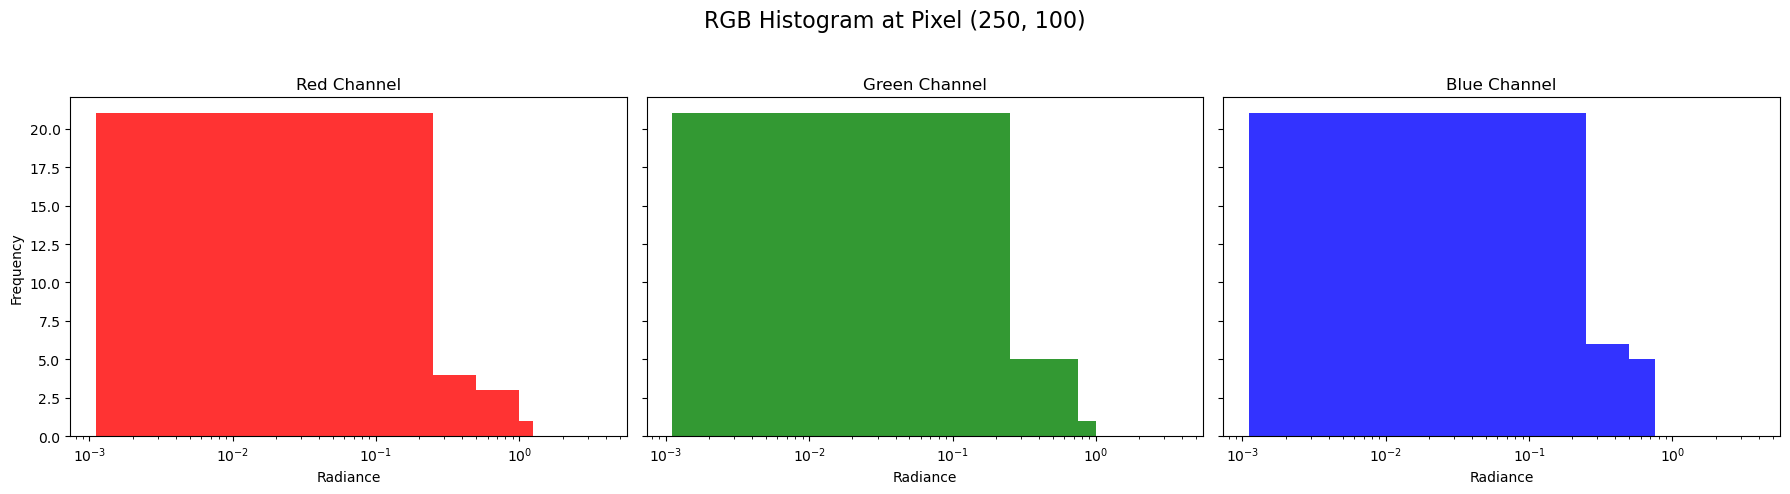

<Figure size 640x480 with 0 Axes>

In [26]:
hist, bin_edg = plot_hist("../data/classroom", 32, 16, log=True)

In [28]:
hist[250, 100, 0, :]

array([ 6,  0,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1, 20],
      dtype=int32)


 XML File Name: scene


Range Val: 10
SPP: 64
Total Pixels: 262144
Linear estimated radiance range: [1.1045e-03, 3.7501e+00]
Image Samples Shape: (512, 512, 3)
Stacked Samples Shape: (512, 512, 64, 3)
Accumulating Histogram ...
Zero samples: 33264996/50331648 (66.09%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0011044664..3.2463007].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0011044664..3.2463007].


Average Histogram Shape:  (512, 512, 3)


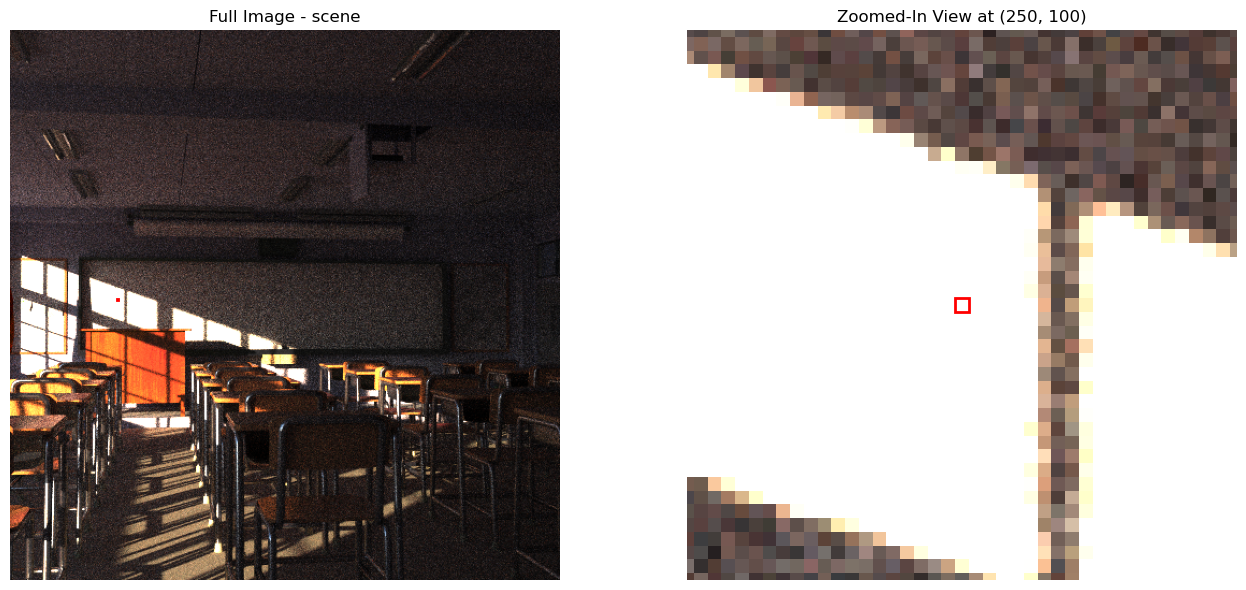

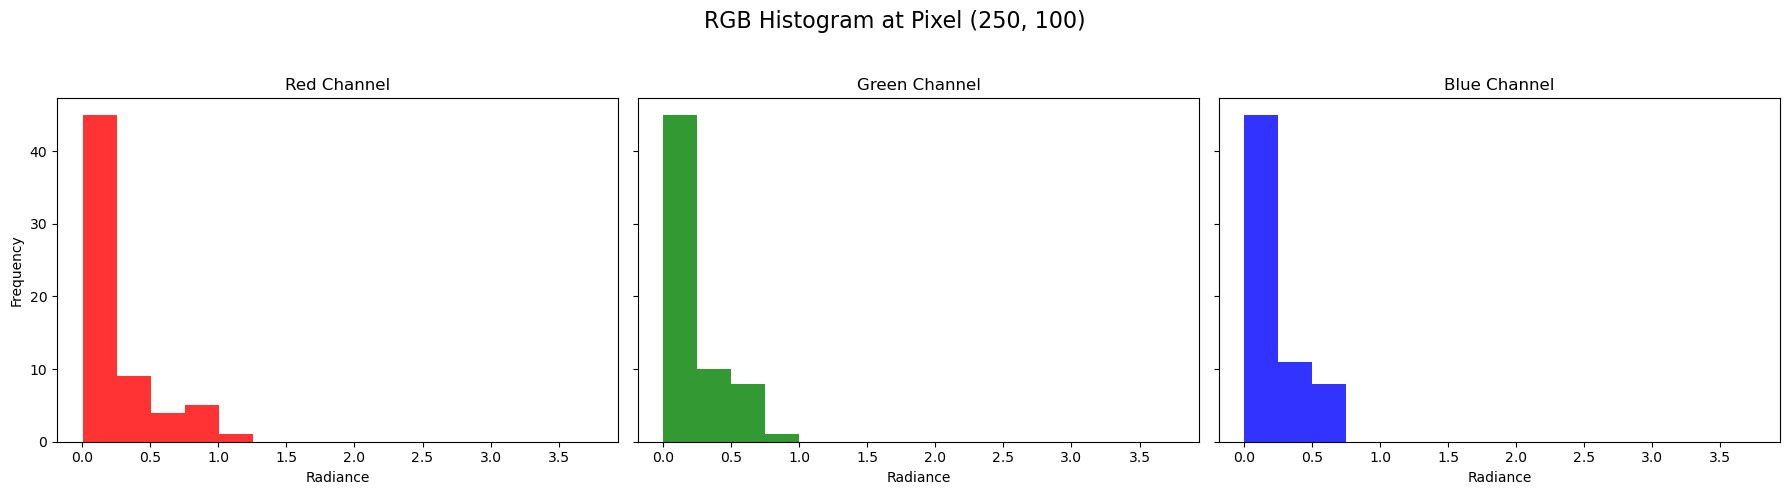

<Figure size 640x480 with 0 Axes>

In [27]:
plot_hist("../data/classroom", 64, 32)

# Albedo Histograms

In [4]:
import os
import sys
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# Get the parent directory (project root) and add it to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)


from dataset.HistogramGenerator import generate_histograms, estimate_range

In [7]:
def reconstruct_image_from_hist(hist, bin_edges):
    """
    hist: (H, W, 3, num_bins)
    bin_edges: (num_bins + 1,)
    Returns: (H, W, 3) reconstructed image
    """
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = bin_centers.reshape(1, 1, 1, -1)  # For broadcasting

    # Normalize histogram per-pixel per-channel
    hist = hist / (np.sum(hist, axis=-1, keepdims=True) + 1e-8)

    # Expected value per pixel-channel
    image = np.sum(hist * bin_centers, axis=-1)
    return image

In [8]:
# Print statistics
def print_stats(name, data):
    flat = data.reshape(-1, 3)
    print(f"\n{name} Stats (R, G, B):")
    print(f"  Mean : {flat.mean(axis=0)}")
    print(f"  Std  : {flat.std(axis=0)}")
    print(f"  Min  : {flat.min(axis=0)}")
    print(f"  Max  : {flat.max(axis=0)}")

In [11]:
def generate_and_plot_histograms(scene_dir, spp_filename, num_bins=32, spp_index=0, device='cuda'):
    """
    Test Log vs. Normal Bins
    
    Args:
        scene_dir (str): Path to folder containing TIFFs
        spp_filename (str): File with shape (32, H, W, 3)
        albedo_filename (str): File with shape (H, W, 3)
        num_bins (int): Histogram bins
        spp_index (int): Index of 1spp image to show
        device (str): CUDA/CPU
    """
    spp_path = os.path.join(scene_dir, spp_filename)
    spp_samples = tifffile.imread(spp_path).astype(np.float32)  # (32, H, W, 3)

    assert spp_samples.shape[0] == 32, "Expected shape (32, H, W, 3)"
    image = spp_samples[spp_index]  # shape: (H, W, 3)

    print_stats("Original RGB (1spp)", image)

    # Compute histograms
    hist_rgb, bin_edges_rgb = generate_histograms(spp_samples, num_bins=num_bins, device=device)
    hist_log, bin_edges_log = generate_histograms(spp_samples, num_bins=num_bins, device=device)

    bin_centers_rgb = 0.5 * (bin_edges_rgb[:-1] + bin_edges_rgb[1:])
    bin_centers_log = 0.5 * (bin_edges_log[:-1] + bin_edges_log[1:])

    image_from_rgb = reconstruct_image_from_hist(hist_rgb, bin_edges_rgb)
    image_from_log = reconstruct_image_from_hist(hist_log, bin_edges_log)

    # --- Plot images ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(10, 5))
    axes1[0].imshow(image_from_rgb)
    axes1[0].set_title("Image from Linear Bins")
    axes1[0].axis("off")

    axes1[1].imshow(image_from_log)
    axes1[1].set_title("Image from Log Bins")
    axes1[1].axis("off")

    plt.tight_layout()
    plt.show()

    # --- Plot histograms ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    px, py = 250, 250

    # Raw RGB histogram (linear bins)
    for c, color in enumerate(["r", "g", "b"]):
        hist_c = hist_rgb[px, py, c, :]
        width = bin_edges_rgb[1:] - bin_edges_rgb[:-1]
        axes2[0].bar(bin_centers_rgb, hist_c, width=width, color=color, alpha=0.5, label=color)
    axes2[0].set_title("Histogram (Raw RGB)")
    axes2[0].set_xlabel("Radiance")
    axes2[0].set_ylabel("Pixel Count")
    axes2[0].legend()

    # Normalized/log RGB histogram
    for c, color in enumerate(["r", "g", "b"]):
        hist_c = hist_log[px, py, c, :]
        width = bin_edges_log[1:] - bin_edges_log[:-1]
        axes2[1].bar(bin_centers_log, hist_c, width=width, color=color, alpha=0.5, label=color)
    axes2[1].set_title("Histogram (Log RGB)")
    axes2[1].set_xlabel("Radiance")
    axes2[1].set_ylabel("Pixel Count")
    axes2[1].set_xscale("log")  # Optional, shows log bin spacing more clearly
    axes2[1].legend()

    plt.tight_layout()
    plt.show()

    return hist_rgb, hist_log, bin_edges_rgb, bin_edges_log


Original RGB (1spp) Stats (R, G, B):
  Mean : [2.441139   1.4347982  0.62273437]
  Std  : [10.847023   6.2812824  2.4890232]
  Min  : [0. 0. 0.]
  Max  : [96.37117  87.888756 21.301151]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2980014184786495..40.23801397283814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2980014184786495..40.23801397283814].


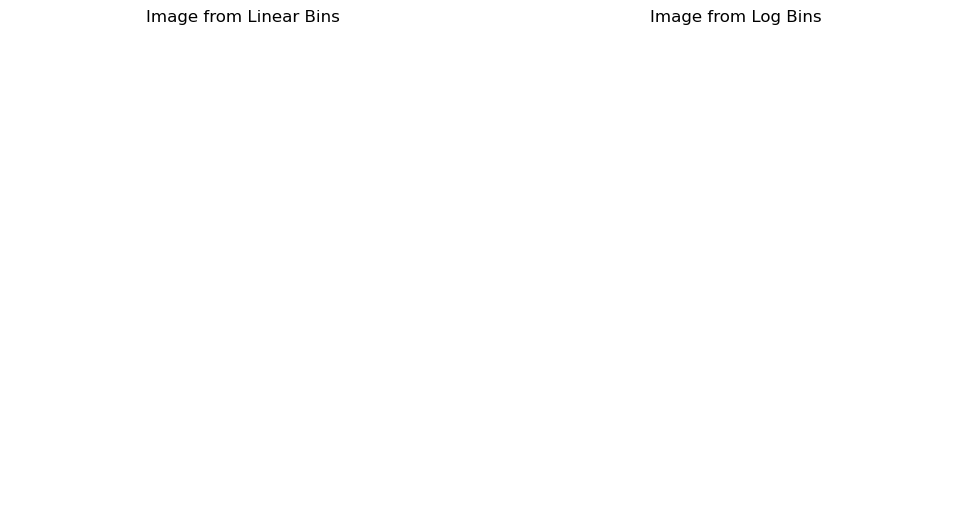

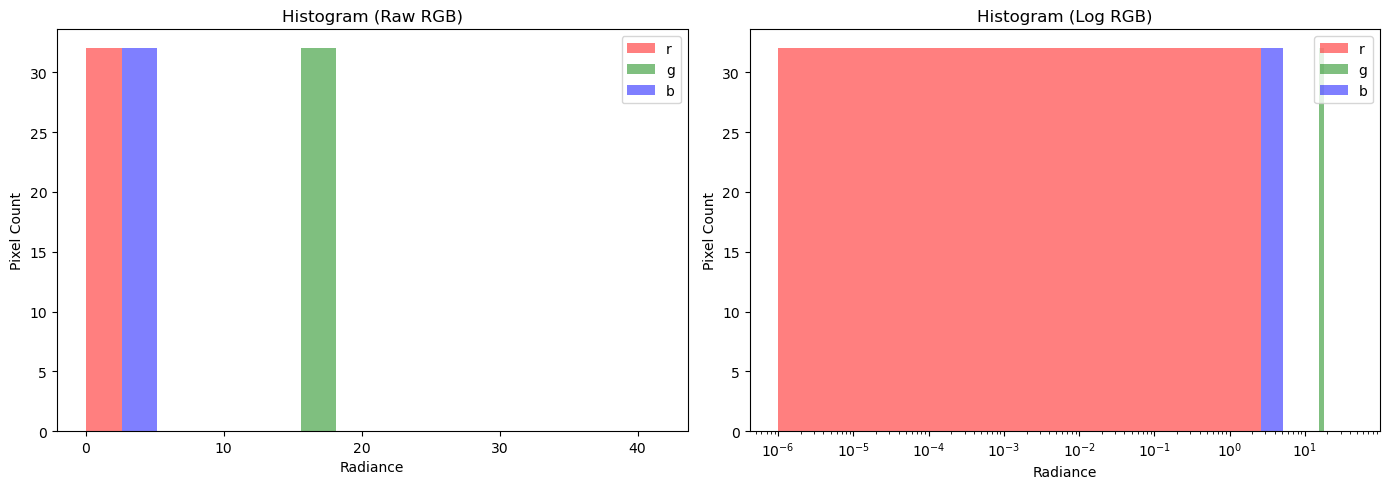

In [12]:
scene_dir = "../output/living-room"
spp_file = "living-room_scene_spp1x32.tiff"

hist_rgb, hist_log, bins_rgb, bins_log = generate_and_plot_histograms(
    scene_dir,
    spp_file,
    num_bins=16,
    spp_index=0,
    device='cpu'  # or 'cpu'
)

In [27]:
print(hist_rgb.shape)
print(hist_log.shape)
print(hist_rgb[250, 250, 0, :])
print(hist_log[250, 250, 0, :])

(512, 512, 3, 16)
(512, 512, 3, 16)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 32]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 32]


In [5]:
def generate_and_plot_histograms(scene_dir, spp_filename, albedo_filename, num_bins=32, spp_index=0, device='cuda'):
    """
    Generate raw and albedo-normalized histograms, plot 1spp + albedo, and show histograms.
    
    Args:
        scene_dir (str): Path to folder containing TIFFs
        spp_filename (str): File with shape (32, H, W, 3)
        albedo_filename (str): File with shape (H, W, 3)
        num_bins (int): Histogram bins
        spp_index (int): Index of 1spp image to show
        device (str): CUDA/CPU
    """
    spp_path = os.path.join(scene_dir, spp_filename)
    albedo_path = os.path.join(scene_dir, albedo_filename)

    # Load data
    spp_samples = tifffile.imread(spp_path).astype(np.float32)  # (32, H, W, 3)
    albedo = tifffile.imread(albedo_path).astype(np.float32)    # (H, W, 3)

    assert spp_samples.ndim == 4 and spp_samples.shape[0] == 32, "Expected shape (32, H, W, 3)"

    N, H, W, C = spp_samples.shape
    image = spp_samples[spp_index]  # shape: (H, W, 3)
    albedo_safe = albedo + 1e-4     # avoid divide-by-zero
    image_normalized = image / albedo_safe

    # Print statistics
    def print_stats(name, data):
        flat = data.reshape(-1, 3)
        print(f"\n{name} Stats (R, G, B):")
        print(f"  Mean : {flat.mean(axis=0)}")
        print(f"  Std  : {flat.std(axis=0)}")
        print(f"  Min  : {flat.min(axis=0)}")
        print(f"  Max  : {flat.max(axis=0)}")

    print_stats("Original RGB (1spp)", image)
    print_stats("Albedo", albedo)
    print_stats("Normalized RGB (1spp / albedo)", image_normalized)

    # Compute histograms
    hist_rgb, bin_edges_rgb = generate_histograms(spp_samples, num_bins=num_bins, device=device)
    normalized_samples = spp_samples / albedo_safe[None, :, :, :]
    hist_norm, bin_edges_norm = generate_histograms(normalized_samples, num_bins=num_bins, device=device)

    # --- Plot images ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(10, 5))
    axes1[0].imshow(np.clip(image, 0, 1))
    axes1[0].set_title(f"1spp Image (index {spp_index})")
    axes1[0].axis("off")

    axes1[1].imshow(np.clip(albedo, 0, 1))
    axes1[1].set_title("Albedo")
    axes1[1].axis("off")

    plt.tight_layout()
    plt.show()

    # --- Plot histograms ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

    centers_rgb = 0.5 * (bin_edges_rgb[:-1] + bin_edges_rgb[1:])
    centers_norm = 0.5 * (bin_edges_norm[:-1] + bin_edges_norm[1:])

    # Raw RGB
    for c, color in enumerate(["r", "g", "b"]):
        hist_c = hist_rgb[:, :, c, :].sum(axis=(0, 1))
        axes2[0].plot(centers_rgb, hist_c, color=color)
    axes2[0].set_title("Histogram (Raw RGB)")
    axes2[0].set_xlabel("Radiance")
    axes2[0].set_ylabel("Pixel Count")

    # Normalized RGB
    for c, color in enumerate(["r", "g", "b"]):
        hist_c = hist_norm[:, :, c, :].sum(axis=(0, 1))
        axes2[1].plot(centers_norm, hist_c, color=color)
    axes2[1].set_title("Histogram (RGB / Albedo)")
    axes2[1].set_xlabel("Normalized Radiance")
    axes2[1].set_ylabel("Pixel Count")

    plt.tight_layout()
    plt.show()

    return hist_rgb, hist_norm, bin_edges_rgb, bin_edges_norm


Original RGB (1spp) Stats (R, G, B):
  Mean : [2.441139   1.4347982  0.62273437]
  Std  : [10.847023   6.2812824  2.4890232]
  Min  : [0. 0. 0.]
  Max  : [96.37117  87.888756 21.301151]

Albedo Stats (R, G, B):
  Mean : [0.4509749  0.3940615  0.36639896]
  Std  : [0.3650422  0.38960084 0.4069552 ]
  Min  : [0. 0. 0.]
  Max  : [64.86972 64.15375 64.23093]

Normalized RGB (1spp / albedo) Stats (R, G, B):
  Mean : [20773.742  11856.209   4719.0215]
  Std  : [107824.195  62094.316  24193.654]
  Min  : [0. 0. 0.]
  Max  : [963711.75 878887.56 203200.11]


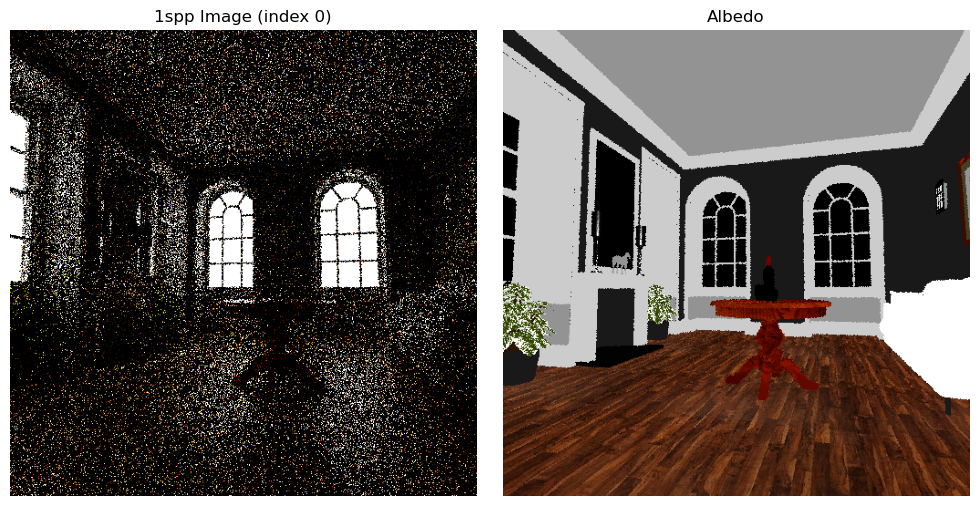

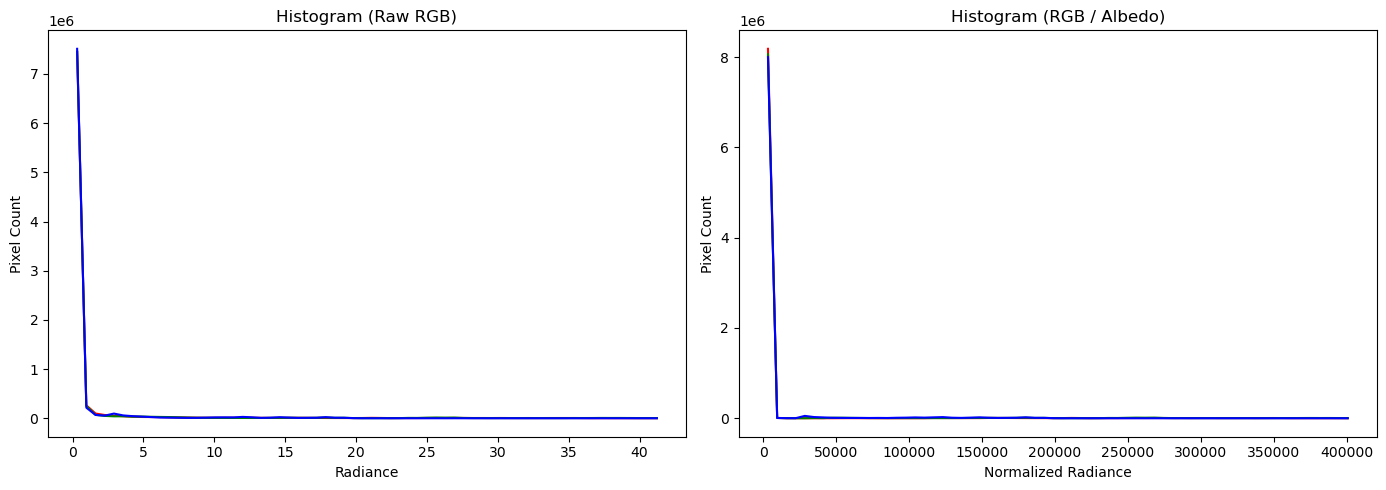

In [6]:
scene_dir = "../output/living-room"
spp_file = "living-room_scene_spp1x32.tiff"
albedo_file = "albedo.tiff"

hist_rgb, hist_norm, bins_rgb, bins_norm = generate_and_plot_histograms(
    scene_dir,
    spp_file,
    albedo_file,
    num_bins=64,
    spp_index=0,
    device='cuda'  # or 'cpu'
)

In [24]:
import torch
import time

def batched_histogram_32batch(images, num_bins=256):
    """
    Compute histograms per pixel across batch dimension for images of shape (B, C, H, W).

    Works on both CPU and CUDA tensors.

    Returns:
      histograms: tensor of shape (C, H, W, num_bins)
    """
    batch_size, channels, H, W = images.shape
    device = images.device

    images_reshaped = images.permute(1, 2, 3, 0)  # (C, H, W, B)
    flattened = images_reshaped.reshape(-1, batch_size)  # (C*H*W, B)

    histograms = torch.zeros(flattened.size(0), num_bins, dtype=torch.int32, device=device)

    # If CUDA, use torch.cuda.Event for timing; else, use time.time()
    if device.type == 'cuda':
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        start_event.record()
        for i in range(flattened.size(0)):
            histograms[i] = torch.bincount(flattened[i], minlength=num_bins)
        end_event.record()

        torch.cuda.synchronize()
        elapsed_ms = start_event.elapsed_time(end_event)
        print(f"Time taken on GPU: {elapsed_ms:.2f} ms")

    else:
        start_time = time.time()
        for i in range(flattened.size(0)):
            histograms[i] = torch.bincount(flattened[i], minlength=num_bins)
        elapsed_ms = (time.time() - start_time) * 1000
        print(f"Time taken on CPU: {elapsed_ms:.2f} ms")

    histograms = histograms.reshape(channels, H, W, num_bins)
    return histograms

In [27]:
# CUDA
if torch.cuda.is_available():
    images_cuda = torch.randint(0, 256, (32, 3, 512, 512), dtype=torch.int64, device='cuda')
    print("Imgaes Shape: ", images_cuda.shape)
    hist_gpu = batched_histogram_32batch(images_cuda)

# CPU
images_cpu = torch.randint(0, 256, (32, 3, 512, 512), dtype=torch.int64, device='cpu')
print("Imgaes Shape: ", images_cpu.shape)
hist_cpu = batched_histogram_32batch(images_cpu)

Imgaes Shape:  torch.Size([32, 3, 512, 512])


In [3]:
import numpy as np
import numba
from numba import prange
import time

@numba.njit(parallel=True)
def fast_batched_histogram(data, batch_size, channels, H, W, num_bins):
    # data shape: (batch_size, channels, H, W), dtype uint8 or int64
    # output: (channels, H, W, num_bins)
    histograms = np.zeros((channels, H, W, num_bins), dtype=np.int32)

    for c in prange(channels):
        for y in prange(H):
            for x in prange(W):
                # Compute histogram over batch dimension
                for b in range(batch_size):
                    val = data[b, c, y, x]
                    histograms[c, y, x, val] += 1
    return histograms

# Prepare data in NumPy
batch_size, channels, H, W = 32, 3, 512, 512
num_bins = 256

# Random data (uint8)
data_np = np.random.randint(0, 256, size=(batch_size, channels, H, W), dtype=np.uint8)

start = time.time()
histograms = fast_batched_histogram(data_np, batch_size, channels, H, W, num_bins)
end = time.time()

print(f"Numba CPU histogram time: {end - start:.2f} seconds")

Numba CPU histogram time: 5.74 seconds
